# Project: Natural Language Processing & Clustering
## Purpose: for clinical trial data, how are different inclusion, exclusion, and outcome criteria related (i.e., how do they cluster)?

Matthew Stachyra
Kaishi Zhou

### Strategy
The final strategy was kmeans, tuned with elbow and silhouette plots after doing standard NLP text preprocessing. Here is how we got to our final results:

We used PyCaret to quickly deploy an LDA model to perform some initial EDA. We wanted to do more with PyCaret but it is a limited tool. It didn't let us control the preprocessing steps or hyperparameters for LDA. Nor did it let us extract a dataframe with the topics. Therefore, it served purely as EDA and gave us some insight into what clusters to expect for `pain` in the inclusion, exclusion, and outcome datasets; and what # of topics to input for LDA. Building on what we learned there, we deployed LDA and kmeans models. 

**1. First Approach (Topic Modeling with PyCaret LDA):**
PyCaret automates the NLP and topic modeling process. As mentioned earlier in the notebook, the preprocessing it does is standard in NLP (i.e., lower case, removing punctuation, lemmatizing, removing stop words). Their pipeline also produces bigrams and trigrams and uses a count vectorizer.

For this we have used the `LDA` (Latent Dirichlet Allocation) probabilistic model. Topic modelling refers to the task of identifying topics that best describes a set of documents. Each topic is composed of keywords.

After creating the model, we used `evaluate_model` which provides a graphical interface where we can view the topics and words composing the topics for unigrams, bigrams, and trigrams. This is where the bulk of our analysis happened. We included pngs because PyCaret doesn't given you a dataframe with the topics.

We learned that the appropriate number of topics for inclusion may be 4, and for exclusion and outcoems may be 8. We also learned that bigrams and trigrams seemed to give better, more cohesive clusters. Based on that we created an LDA model with gensim where we had more flexibility with the model that PyCaret doesn't offer

**1. Second Approach (Topic Modelling with gensim LDA):**<br>
For the non-PyCaret models, we performed the same data cleaning and preprocessing. Steps: lowering case; removing spaces, punctuation, stop words; expanding contractions; removing words over length 20 and under length 3; lemmatizing the words; and splitting into tokens. We also trained using unigrams, bigrams, and trigrams. In the case of kmeans we use TFIDF vectorization.

We then developed 3 LDA models for each of inclusion, exclusion, and outcome. Each was tuned by plotting elbow plots. We were able to see that the right number of topics was the same as what we saw with PyCaret.

**3. Third Approach (Clustering with kmeans):**<br>
We have used the clustering in the second approach where we applied `Kmeans` clustering technique with `TFIDF Vectorization` to find the similar group for inclusion, exclusion and outcome for each trial.

`TFIDF Vectrization` will tokenize documents, learn the vocabulary and inverse document frequency weightings, and allow you to encode new documents. TFIDF works by proportionally increasing the number of times a word appears in the document but is counter balanced by the number of documents in which it is present.

`Kmeans` clustering is a type of unsupervised learning, which is used when you have unlabeled data (i.e., data without defined categories or groups). The goal of this algorithm is to find groups in the data, with the number of groups represented by the variable K. The algorithm works iteratively to assign each data point to one of K groups based on the features that are provided. Data points are clustered based on feature similarity.

We tuned the kmeans models using elbow and silhoette plots. Where we saw the elbow as well as a high silhoette score (as we matched up the axes for these plots) we chose that for k or number of clusters.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from pycaret.clustering import *
from pycaret.nlp import *

from tqdm import tqdm
tqdm.pandas()

from tqdm import tqdm_notebook
tqdm_notebook().pandas()

import re,string
from nltk.corpus import stopwords

warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

import gensim
import gensim.corpora as corpora
from gensim import matutils
from gensim.models import CoherenceModel
import gensim.downloader as api

import nltk
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
%matplotlib inline

from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances

0it [00:00, ?it/s]

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/matthewstachyra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
inclusion = pd.read_csv('./inclusion/Pain.txt',sep='\t')
exclusion = pd.read_csv('./exclusion/Pain.txt',sep='\t')
outcome = pd.read_csv('./outcome/Pain.txt',sep='\t')

outcome = outcome[~outcome['description'].isna()]

In [72]:
inclusion.head()

,NCT#,phase,condition,sponsor,start_date,mesh_list,criterion
0,NCT00002160,Phase 2,HIV Infections;Cancer;Pain,Neurex,"February 10, 2015",Chronic Pain,Concurrent Medication: Allowed:
1,NCT00002160,Phase 2,HIV Infections;Cancer;Pain,Neurex,"February 10, 2015",Chronic Pain,Rescue analgesia. Patients must have:
2,NCT00002160,Phase 2,HIV Infections;Cancer;Pain,Neurex,"February 10, 2015",Chronic Pain,Chronic pain related to AIDS or cancer.
3,NCT00002160,Phase 2,HIV Infections;Cancer;Pain,Neurex,"February 10, 2015",Chronic Pain,Unsatisfactory response to prior opioid therapy.
4,NCT00002160,Phase 2,HIV Infections;Cancer;Pain,Neurex,"February 10, 2015",Chronic Pain,Life expectancy > 3 months (or 1 month if an i...


In [73]:
exclusion.head()

,NCT#,phase,condition,sponsor,start_date,mesh_list,criterion
0,NCT00002160,Phase 2,HIV Infections;Cancer;Pain,Neurex,"February 10, 2015",Chronic Pain,Co-existing Condition: Patients with the foll...
1,NCT00002160,Phase 2,HIV Infections;Cancer;Pain,Neurex,"February 10, 2015",Chronic Pain,Signs of sepsis or inadequately treated infect...
2,NCT00006427,Phase 4,"Amputation, Traumatic;Pain;Postoperative Pain",Eunice Kennedy Shriver National Institute of C...,"February 10, 2015","Chronic Pain;Amputation, Traumatic","History of cardiovascular disease, seizures, o..."
3,NCT00006427,Phase 4,"Amputation, Traumatic;Pain;Postoperative Pain",Eunice Kennedy Shriver National Institute of C...,"February 10, 2015","Chronic Pain;Amputation, Traumatic",Currently taking antidepressant medications
4,NCT00006427,Phase 4,"Amputation, Traumatic;Pain;Postoperative Pain",Eunice Kennedy Shriver National Institute of C...,"February 10, 2015","Chronic Pain;Amputation, Traumatic",Currently hyperthyroid or taking thyroid medic...


In [74]:
outcome.head()

,NCT#,phase,condition,sponsor,start_date,mesh_list,outcome_type,measure,time_scale,description
0,NCT00002668,NaN,Breast Cancer;Pain;Prostate Cancer,Eastern Cooperative Oncology Group,"February 10, 2015",Breast Neoplasms;Prostatic Neoplasms,primary,Change in pain assessed using the Brief Pain I...,Assessed over 15 days,Change in worst pain from baseline to day 15
1,NCT00006994,Phase 3,Cancer-related Problem/Condition;Head and Neck...,Southwest Oncology Group,"February 10, 2015",Head and Neck Neoplasms;Mucositis,primary,Effectiveness of L-glutamine for mucositis,2 weeks after end of radiation treatment,Evaluate effectiveness of L-glutamine as compa...
9,NCT00026247,NaN,Metastatic Cancer;Pain;Unspecified Adult Solid...,American College of Radiology Imaging Network,"February 10, 2015",Neoplasm Metastasis,primary,Adverse events,1 month post procedure,Estimate the adverse event rate due to RFA wit...
10,NCT00026247,NaN,Metastatic Cancer;Pain;Unspecified Adult Solid...,American College of Radiology Imaging Network,"February 10, 2015",Neoplasm Metastasis,secondary,Pain intensity,1 month post-procedure,pain intensity as measured by VASPI Scale
11,NCT00026247,NaN,Metastatic Cancer;Pain;Unspecified Adult Solid...,American College of Radiology Imaging Network,"February 10, 2015",Neoplasm Metastasis,secondary,Pain intensity,3 months post-procedure,pain intensity as measured by VASPI Scale


## I. LDA with PyCaret
We start with using PyCaret to deploy a model quickly and see what we can learn from an initial model.

### Inclusion

Preprocessing pipeline is automated in PyCaret. The following is completed when `setup()` is called.
- Removing Numeric Characters: All numeric characters are removed from the text. They are replaced with blanks.
- Removing Special Characters: All non-alphanumeric special characters are removed from the text. They are also replaced with blanks.
- Word Tokenization 
- Stopword Removal
- Bigram Extraction
- Trigram Extraction
- Lemmatizing
- Custom Stopwords (if specified)

In [75]:
from pycaret.nlp import *

nlp_setup = setup(data=inclusion, target = 'criterion', session_id = 123)

Description,Value
session_id,123
Documents,9126
Vocab Size,5181
Custom Stopwords,False


In [76]:
# by default, it creates 4 topics
lda = create_model('lda')

In [77]:
# provides an interface where we can choose a visualization by topic
evaluate_model(lda)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Frequency Plot', 'freque…

**Note** By nature of the interface, only one view is possible at one time so the pdf of this notebook won't show everything that we saw. Therefore we provide pictures of the plots and document our findings below.

- Looking at the top 100 words for each of the 4 topics: There doesn't appear to be a common theme to the inclusion criteria for any 1 topic. This suggests the model needs additional tuning / isn't picking up the similar criteria. And, certain words have a much higher frequency than others. We remove the top few words for each topic next.
- Bigrams provide more insight than individual words. We were able to identify discrete clusters that make sense when eyeballing the top 10-20 bigrams for each topic cluster.
- Based on this, we will focus on topic cluster of bigrams rather than individual words as these provide more recognizable clusters. 
- Next we calculate a coherence score to coroborate decent findings from eyeballing the data.

**topic 0:** patients that have or will undergo elective surgery

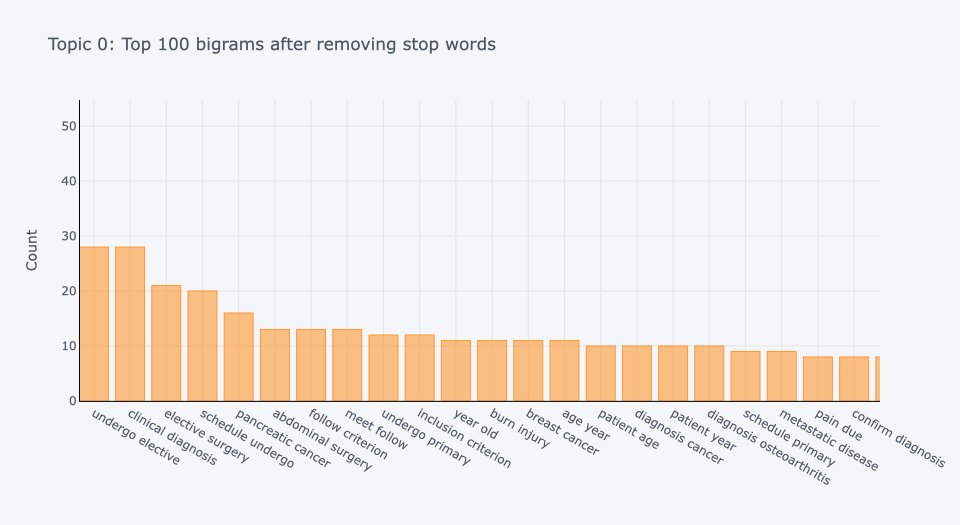

**topic 1:** patients with a certain medical history, such as of good health, not pregnant, psychiatric disorder, or neurological disorder

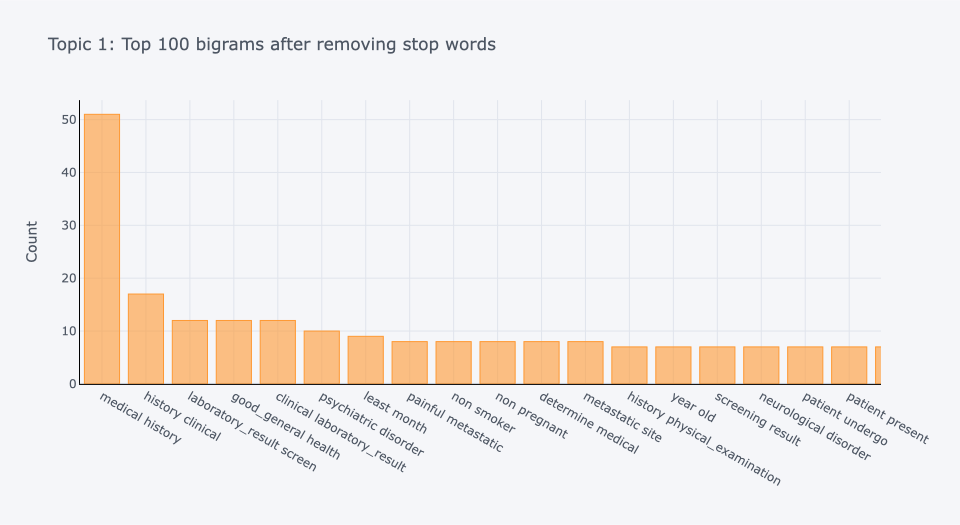

**topic 2:** patients with pain of some length, intensity, or type; and patients taking medication or opioid therapy

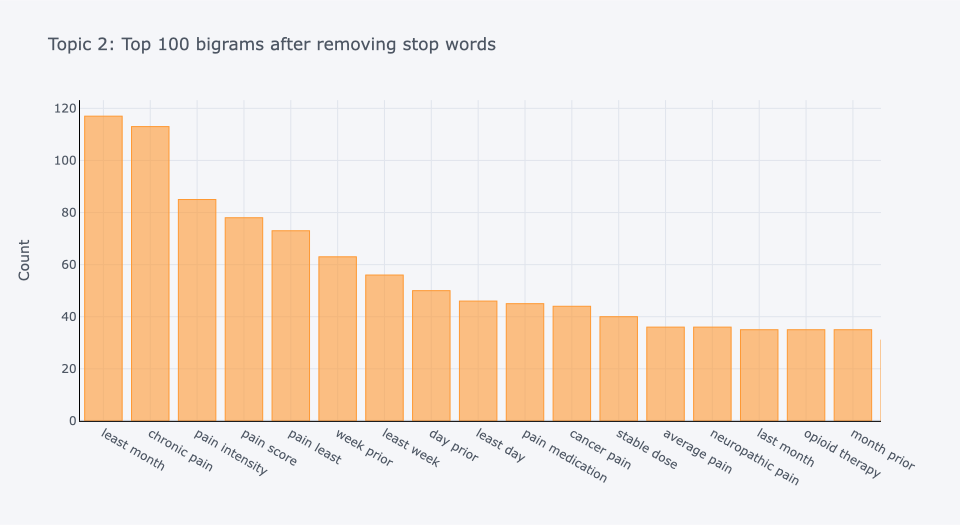

**topic 3:** patients of a certain age

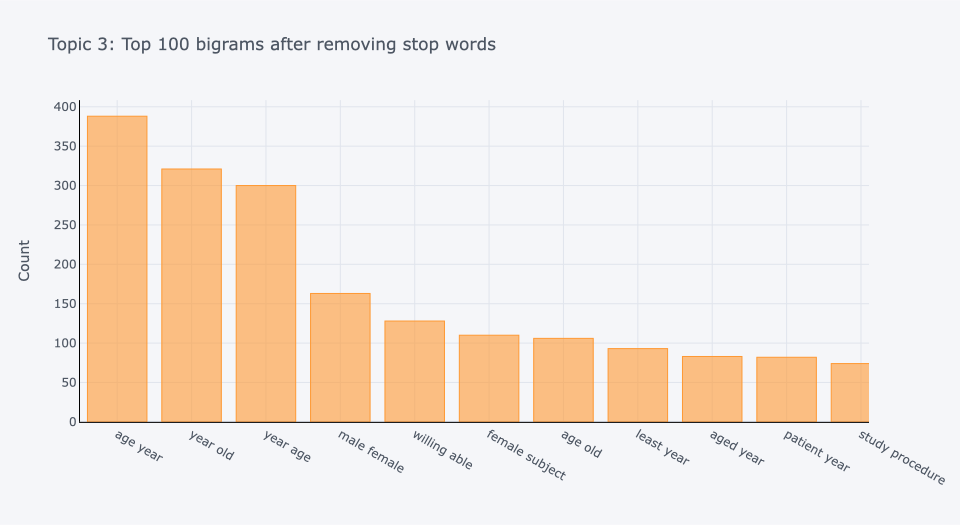

In [78]:
lda_results = assign_model(lda)
lda_results = lda_results[['condition', 'mesh_list','criterion','Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Dominant_Topic', 'Perc_Dominant_Topic']]

In [79]:
lda_results[:10]

,condition,mesh_list,criterion,Topic_0,Topic_1,Topic_2,Topic_3,Dominant_Topic,Perc_Dominant_Topic
0,HIV Infections;Cancer;Pain,Chronic Pain,concurrent medication allow,0.141609,0.515414,0.131553,0.211424,Topic 1,0.52
1,HIV Infections;Cancer;Pain,Chronic Pain,rescue patient must,0.152397,0.324420,0.149567,0.373616,Topic 3,0.37
2,HIV Infections;Cancer;Pain,Chronic Pain,chronic pain relate cancer,0.124499,0.334434,0.115650,0.425416,Topic 3,0.43
3,HIV Infections;Cancer;Pain,Chronic Pain,unsatisfactory_response prior opioid therapy,0.141094,0.529001,0.127707,0.202199,Topic 1,0.53
4,HIV Infections;Cancer;Pain,Chronic Pain,month infusion pump place,0.127653,0.163477,0.131347,0.577523,Topic 3,0.58
5,"Amputation, Traumatic;Pain;Postoperative Pain","Chronic Pain;Amputation, Traumatic",amputation month ago longer,0.284410,0.108032,0.132376,0.475182,Topic 3,0.48
6,"Amputation, Traumatic;Pain;Postoperative Pain","Chronic Pain;Amputation, Traumatic",pain month longer,0.142444,0.108705,0.132388,0.616463,Topic 3,0.62
7,Spinal Cord Injuries;Pain,Spinal Cord Injuries;Chronic Pain;Wounds and I...,month ago longer,0.163887,0.126002,0.154330,0.555781,Topic 3,0.56
8,Spinal Cord Injuries;Pain,Spinal Cord Injuries;Chronic Pain;Wounds and I...,pain month longer,0.142444,0.108706,0.132389,0.616460,Topic 3,0.62
9,"Spinal Cord Injuries;Amputation, Traumatic;Pain",Spinal Cord Injuries;Wounds and Injuries;Amput...,individual amputation persistent pain month lo...,0.355467,0.157650,0.085228,0.401655,Topic 3,0.40


In [80]:
print("Mean percent dominant topic: ", lda_results['Perc_Dominant_Topic'].mean())

Mean percent dominant topic:  0.46871904448827434


**Note** Based on eyeballing the `Perc_Dominant_Topic` column and the mean, we see the model clusters a row to a topic more frequently than chance, which would be 25% here with 4 topics. This suggests the model is picking up on clearly different topic clusters in the data.

IntProgress(value=0, description='Processing: ', max=25)

Output()

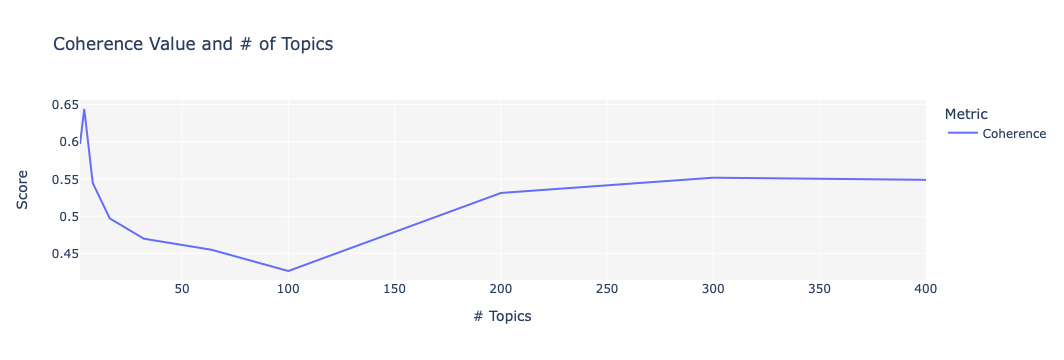

Best Model: Latent Dirichlet Allocation | # Topics: 4 | Coherence: 0.644


In [81]:
tuned_unsupervised = tune_model(model = 'lda', multi_core = True)

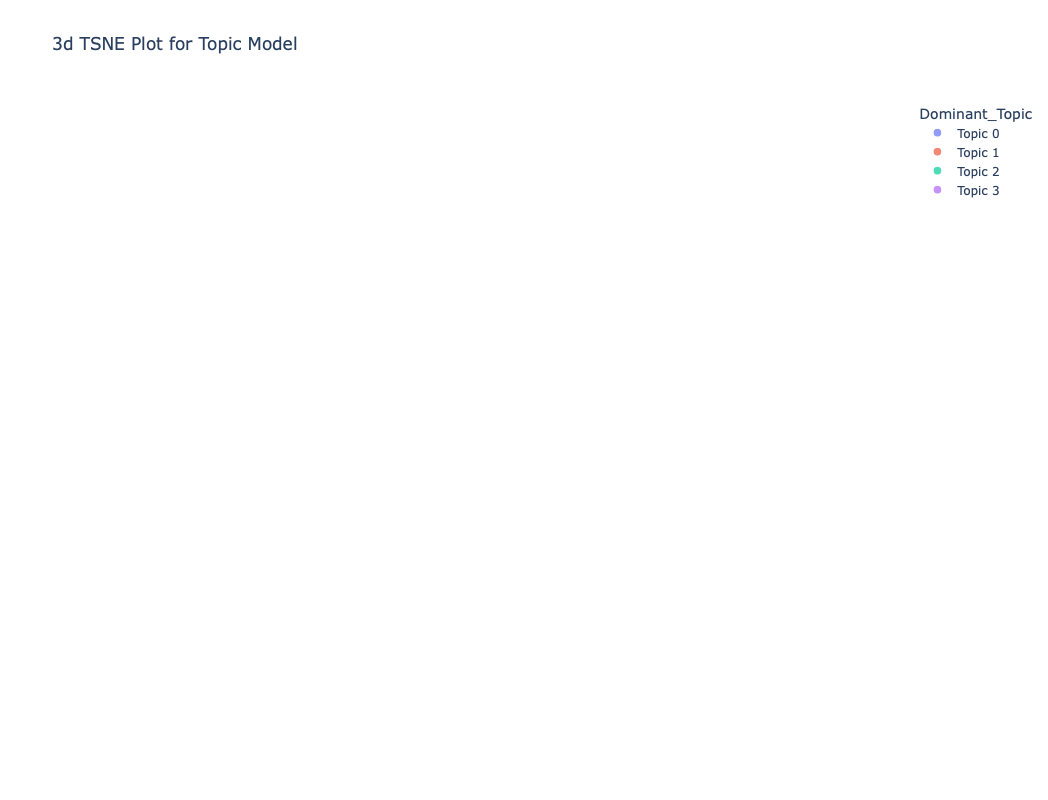

In [82]:
plot_model(lda, plot = 'tsne')

**Note** The TSNE plot offers no insight. It seems to suggest that the 4 topics are not distinct in this 3d space but we know from actually looking a the data that this doesn't seem to be the case.

In [83]:
# we increased to 8 topics to see if we can pick up more nuance in the criteria
lda_8 = create_model('lda', num_topics=8)

In [84]:
evaluate_model(lda_8)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Frequency Plot', 'freque…

**Note** Increasing to 8 topics doesn't improve the topic clusters. We have the same 4 types of criteria we saw earlier and the additional topics capture noise for the most part and have similar entries as other topics.

**Initial observations** based on running PyCaret for the inclusion criteria
- We see that bigrams produce more sensible and easily interpretable clusters than individual words.
- We see there are at least 4 topics for inclusion criteria that make sense.
- We see that coherence is not a particularly good measure here as it suggested less topics than we saw made sense for the data when we actually looked at it.
- A limitation of using PyCaret is I can't extract the bigrams into a dataframe to work with.
- Another limitation is I can't adjust the visualizations (e.g., changing the hyperparameters of the TSNE plot)

### Exclusion

In [85]:
from pycaret.nlp import *

nlp_setup = setup(data=exclusion, target = 'criterion', session_id = 123)

Description,Value
session_id,123
Documents,14675
Vocab Size,6260
Custom Stopwords,False


In [86]:
exclusion.head()

,NCT#,phase,condition,sponsor,start_date,mesh_list,criterion
0,NCT00002160,Phase 2,HIV Infections;Cancer;Pain,Neurex,"February 10, 2015",Chronic Pain,Co-existing Condition: Patients with the foll...
1,NCT00002160,Phase 2,HIV Infections;Cancer;Pain,Neurex,"February 10, 2015",Chronic Pain,Signs of sepsis or inadequately treated infect...
2,NCT00006427,Phase 4,"Amputation, Traumatic;Pain;Postoperative Pain",Eunice Kennedy Shriver National Institute of C...,"February 10, 2015","Chronic Pain;Amputation, Traumatic","History of cardiovascular disease, seizures, o..."
3,NCT00006427,Phase 4,"Amputation, Traumatic;Pain;Postoperative Pain",Eunice Kennedy Shriver National Institute of C...,"February 10, 2015","Chronic Pain;Amputation, Traumatic",Currently taking antidepressant medications
4,NCT00006427,Phase 4,"Amputation, Traumatic;Pain;Postoperative Pain",Eunice Kennedy Shriver National Institute of C...,"February 10, 2015","Chronic Pain;Amputation, Traumatic",Currently hyperthyroid or taking thyroid medic...


In [87]:
lda_exclusion = create_model('lda')

In [88]:
evaluate_model(lda_exclusion)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Frequency Plot', 'freque…

- Like for the inclusion dataset, bigrams are more telling than the individual words.
- However, the 4 topic clusters using bigrams aren't as cleanly divided for exclusion criteria as they were for the inclusion criteria. 
- Basically all 4 topics have a smattering of diseases and disorders within them without clear similarity. For example, one topic had psychiatric illness, pulmonary disease, and renal function all in one. This could be interpreted as one topic for one general exclusion criteria of having a complicating illness.
- That said, exploring the data using trigrams produced somewhat better results. The topics had 1-3 major groups within them that could be readily identified. Of course, that suggests we need to increase the number of topics generated, which we do next. The topic clusters using 4 topics and trigrams are below.

**topic 0:** combination of two major criteria (1) past alcohol or drug abuse and (2) prior study entry

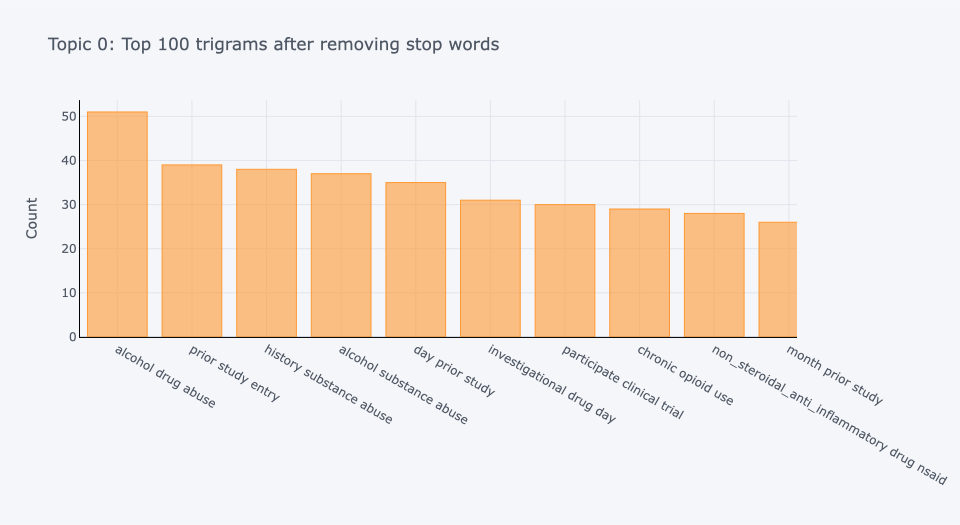

**topic 1:** combination of a few criteria (1) history of seizure, (2) infection, (3) bipolar, (4) implant

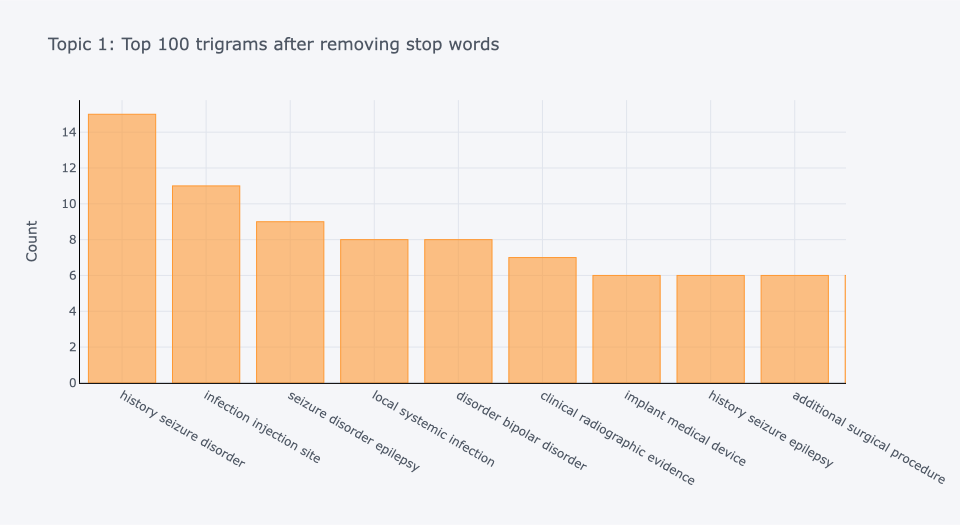

**topic 2:** combination of a few criteria (1) pulmonary disease, (2) difficulty communicating, (3) kidney disease

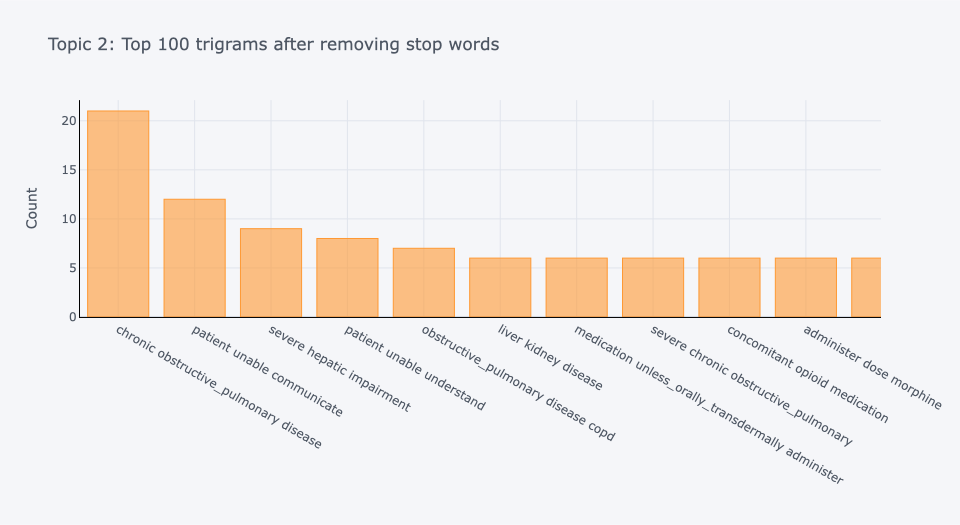

**topic 3:** combination of a couple criteria (1) any condition or history that in investigator's opinion precludes patient from participation, (2) chronic pain

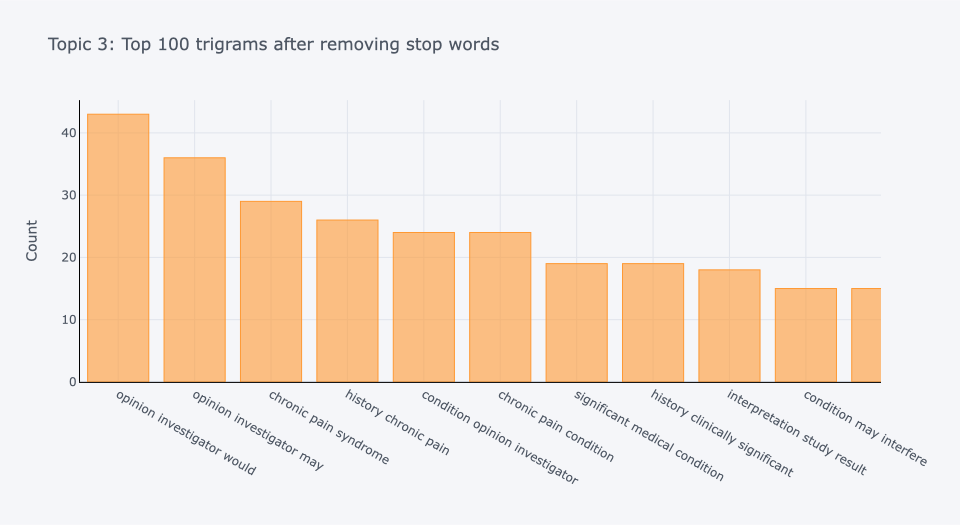

In [89]:
lda_exclusion_results = assign_model(lda_exclusion)
lda_exclusion_results = lda_exclusion_results[['condition', 'mesh_list','criterion','Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Dominant_Topic', 'Perc_Dominant_Topic']]

In [90]:
lda_exclusion_results.head()

,condition,mesh_list,criterion,Topic_0,Topic_1,Topic_2,Topic_3,Dominant_Topic,Perc_Dominant_Topic
0,HIV Infections;Cancer;Pain,Chronic Pain,co exist condition patient follow symptom cond...,0.127018,0.085610,0.315098,0.472275,Topic 3,0.47
1,HIV Infections;Cancer;Pain,Chronic Pain,sign sepsis inadequately treat infection patie...,0.176108,0.105018,0.252651,0.466222,Topic 3,0.47
2,"Amputation, Traumatic;Pain;Postoperative Pain","Chronic Pain;Amputation, Traumatic",history cardiovascular disease seizure,0.289840,0.238442,0.343732,0.127986,Topic 2,0.34
3,"Amputation, Traumatic;Pain;Postoperative Pain","Chronic Pain;Amputation, Traumatic",currently take antidepressant medication,0.515644,0.123520,0.232836,0.128000,Topic 0,0.52
4,"Amputation, Traumatic;Pain;Postoperative Pain","Chronic Pain;Amputation, Traumatic",currently take thyroid medication,0.626051,0.123573,0.122304,0.128072,Topic 0,0.63


In [91]:
print("Mean percent dominant topic: ", lda_exclusion_results['Perc_Dominant_Topic'].mean())

Mean percent dominant topic:  0.4385417376490741


IntProgress(value=0, description='Processing: ', max=25)

Output()

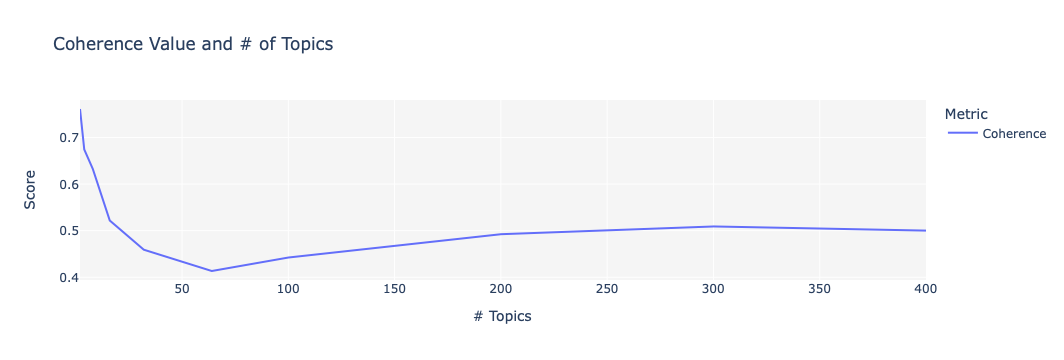

Best Model: Latent Dirichlet Allocation | # Topics: 2 | Coherence: 0.7611


In [92]:
# finding optimal number of topics for lda model (still focusing on using trigrams)
tuned_unsupervised = tune_model(model = 'lda', multi_core = True)

In [93]:
# we try 8 topics as we see that we maintain a coherence > 0.6 at this level 
# and this may allow us to extract additional topics
lda_exclusion_8 = create_model('lda', num_topics=8)

In [94]:
evaluate_model(lda_exclusion_8)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Frequency Plot', 'freque…

**Note** Increasing the number of topics cleaned up previous clusters and pulled out new clusters (e.g., pregnancy as an exclusion criteria)

**topic 0:** cleaned up so it focuses on past substance abuse

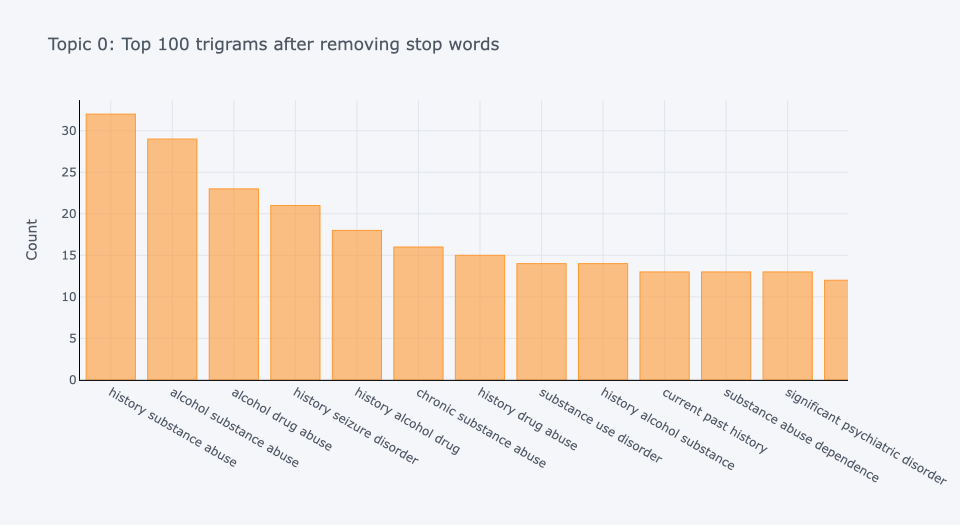

**topic 1:** new topic around inability to understand or communicate (note: this is has a very small amount of the rows represented)

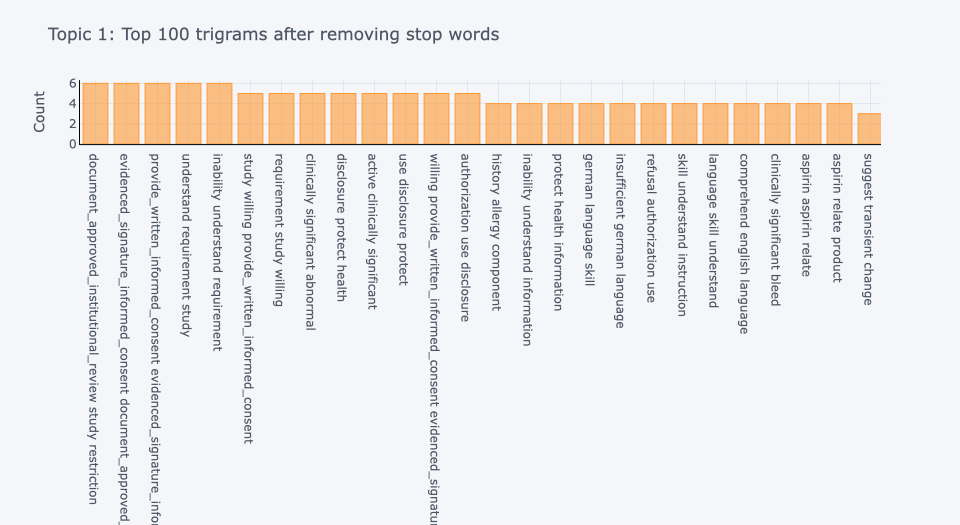

**topic 2:** cleaned up what was previously topic 3. Removed some of the unlike criteria we had before like 'chronic pain condition' to focus on the exclusion criteria here around an investigator's opinion that the patient is unfit for the study.

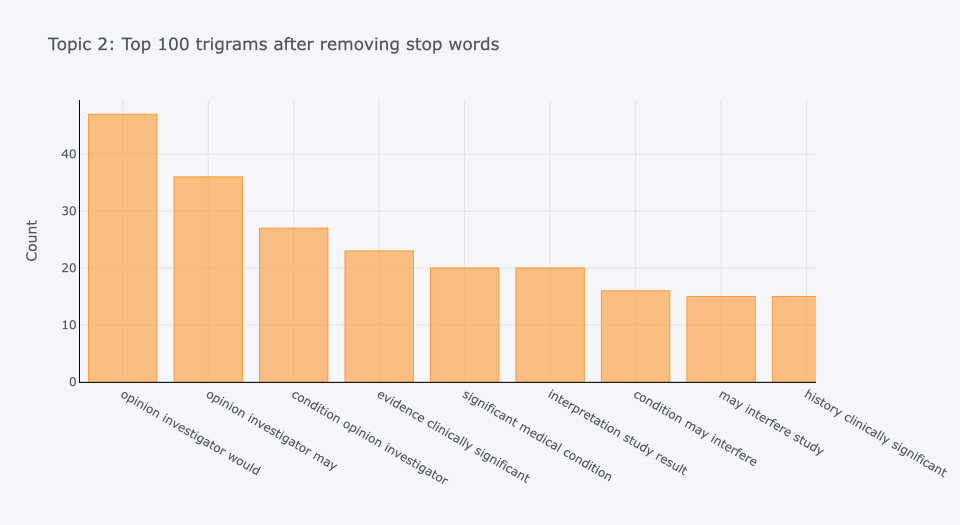

**topic 3:** is a collection of noise unfortunetly. It mixes exclusion criteria like pregnanancy and infection

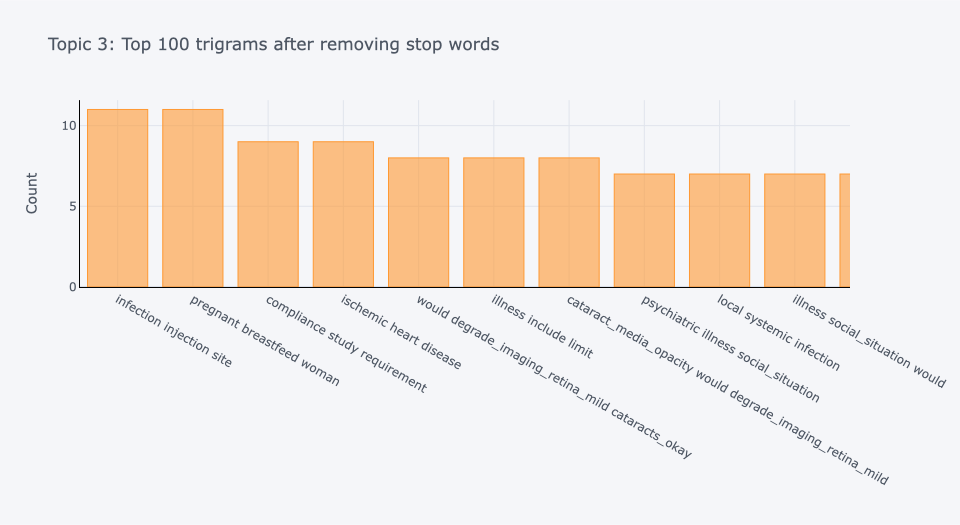

**topic 4:** like topic 3, this too is a collection of noise with multiple exclusion criteria combined

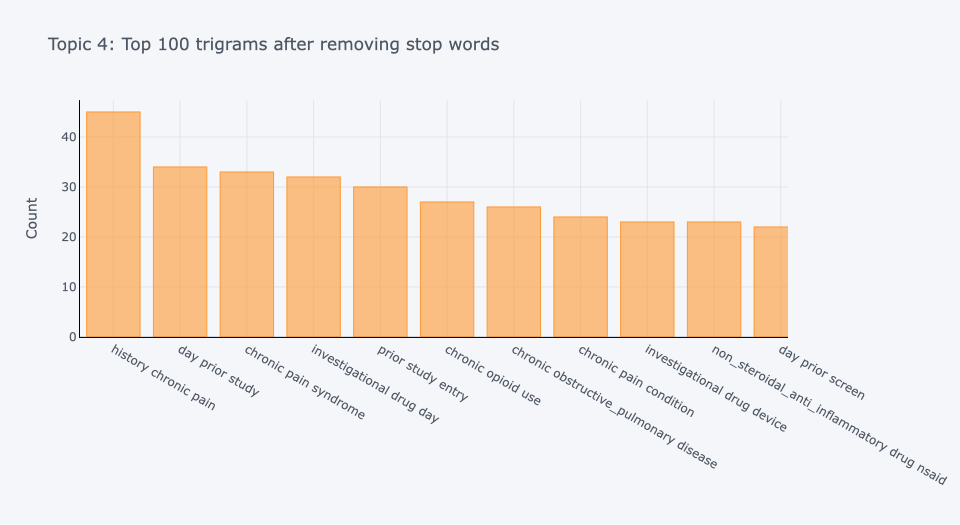

**topic 5:** new cluster for pregnancy

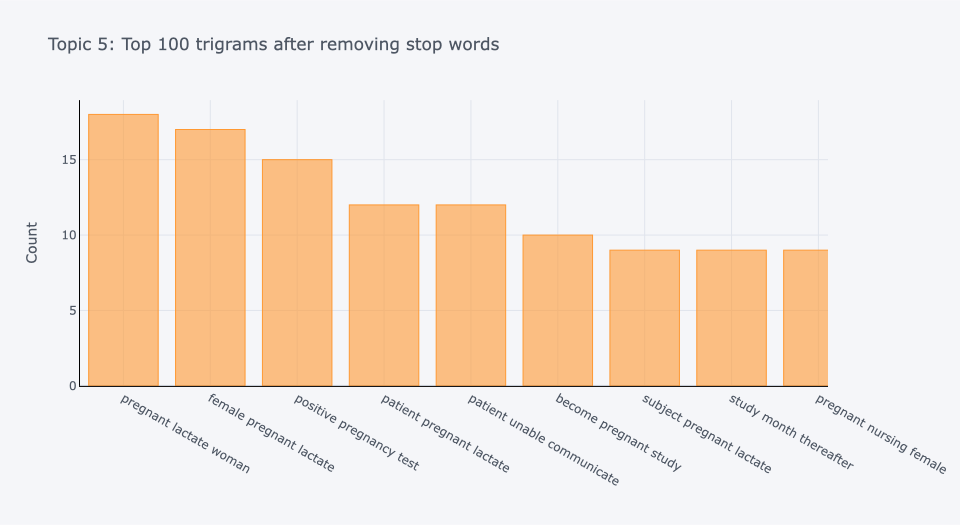

**topic 6:** somewhat focused cluster on excluding patients where something happened in the prior month or if they already participated in the study before. Oddly this topic captures some rows with pregnancy, which was in the previous topic

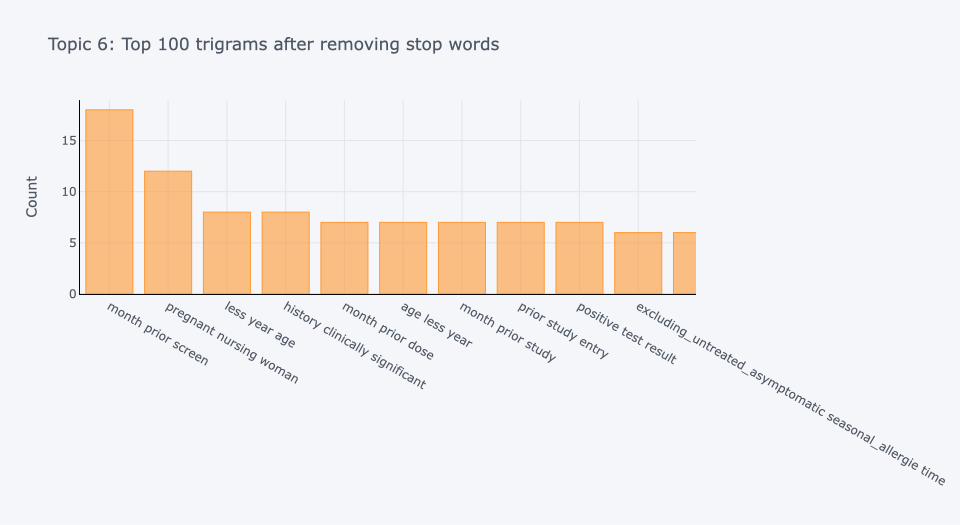

**topic 7:** morphine or opioid use

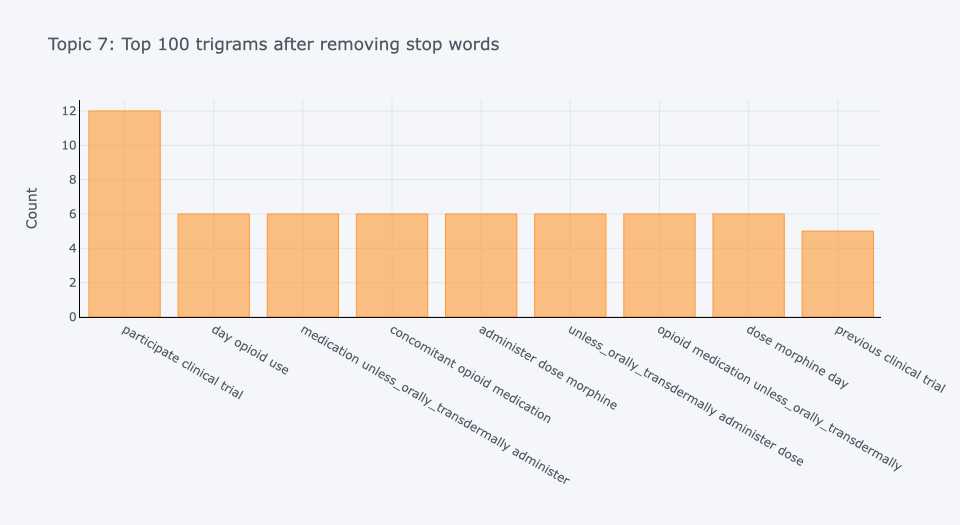

### Outcome

In [95]:
outcome = outcome.reset_index()
outcome.head()

,index,NCT#,phase,condition,sponsor,start_date,mesh_list,outcome_type,measure,time_scale,description
0,0,NCT00002668,NaN,Breast Cancer;Pain;Prostate Cancer,Eastern Cooperative Oncology Group,"February 10, 2015",Breast Neoplasms;Prostatic Neoplasms,primary,Change in pain assessed using the Brief Pain I...,Assessed over 15 days,Change in worst pain from baseline to day 15
1,1,NCT00006994,Phase 3,Cancer-related Problem/Condition;Head and Neck...,Southwest Oncology Group,"February 10, 2015",Head and Neck Neoplasms;Mucositis,primary,Effectiveness of L-glutamine for mucositis,2 weeks after end of radiation treatment,Evaluate effectiveness of L-glutamine as compa...
2,9,NCT00026247,NaN,Metastatic Cancer;Pain;Unspecified Adult Solid...,American College of Radiology Imaging Network,"February 10, 2015",Neoplasm Metastasis,primary,Adverse events,1 month post procedure,Estimate the adverse event rate due to RFA wit...
3,10,NCT00026247,NaN,Metastatic Cancer;Pain;Unspecified Adult Solid...,American College of Radiology Imaging Network,"February 10, 2015",Neoplasm Metastasis,secondary,Pain intensity,1 month post-procedure,pain intensity as measured by VASPI Scale
4,11,NCT00026247,NaN,Metastatic Cancer;Pain;Unspecified Adult Solid...,American College of Radiology Imaging Network,"February 10, 2015",Neoplasm Metastasis,secondary,Pain intensity,3 months post-procedure,pain intensity as measured by VASPI Scale


In [96]:
from pycaret.nlp import *

setup = setup(data=outcome, target='description', session_id = 123)

Description,Value
session_id,123
Documents,10699
Vocab Size,6955
Custom Stopwords,False


In [97]:
outcome_model = create_model('lda')

In [98]:
lda_results = assign_model(outcome_model)

In [99]:
lda_results.head()

,index,NCT#,phase,condition,sponsor,start_date,mesh_list,outcome_type,measure,time_scale,description,Topic_0,Topic_1,Topic_2,Topic_3,Dominant_Topic,Perc_Dominant_Topic
0,0,NCT00002668,NaN,Breast Cancer;Pain;Prostate Cancer,Eastern Cooperative Oncology Group,"February 10, 2015",Breast Neoplasms;Prostatic Neoplasms,primary,Change in pain assessed using the Brief Pain I...,Assessed over 15 days,change bad pain baseline day,0.116143,0.732837,0.087344,0.063675,Topic 1,0.73
1,1,NCT00006994,Phase 3,Cancer-related Problem/Condition;Head and Neck...,Southwest Oncology Group,"February 10, 2015",Head and Neck Neoplasms;Mucositis,primary,Effectiveness of L-glutamine for mucositis,2 weeks after end of radiation treatment,evaluate glutamine compare placebo term maximu...,0.410040,0.537767,0.030843,0.021350,Topic 1,0.54
2,9,NCT00026247,NaN,Metastatic Cancer;Pain;Unspecified Adult Solid...,American College of Radiology Imaging Network,"February 10, 2015",Neoplasm Metastasis,primary,Adverse events,1 month post procedure,estimate rate due rfa period,0.239053,0.461905,0.097827,0.201214,Topic 1,0.46
3,10,NCT00026247,NaN,Metastatic Cancer;Pain;Unspecified Adult Solid...,American College of Radiology Imaging Network,"February 10, 2015",Neoplasm Metastasis,secondary,Pain intensity,1 month post-procedure,pain intensity measure vaspi scale,0.143856,0.673287,0.109908,0.072949,Topic 1,0.67
4,11,NCT00026247,NaN,Metastatic Cancer;Pain;Unspecified Adult Solid...,American College of Radiology Imaging Network,"February 10, 2015",Neoplasm Metastasis,secondary,Pain intensity,3 months post-procedure,pain intensity measure vaspi scale,0.143856,0.673262,0.109934,0.072948,Topic 1,0.67


In [100]:
evaluate_model(outcome_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Frequency Plot', 'freque…

**Note** 4 topics looks to be too much. Quickly looking at the plots for the bigrams and trigrams for the default of 4 topics shows that threre are 2-3 major topics (outcome criteria) arise: degree of pain, threshold to pain, and perceptible pain relief.

In [101]:
lda_outcome_results = assign_model(outcome_model)
lda_outcome_results = lda_outcome_results[['condition', 'description','Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Dominant_Topic', 'Perc_Dominant_Topic']]

In [102]:
lda_outcome_results.head()

,condition,description,Topic_0,Topic_1,Topic_2,Topic_3,Dominant_Topic,Perc_Dominant_Topic
0,Breast Cancer;Pain;Prostate Cancer,change bad pain baseline day,0.116143,0.732837,0.087344,0.063675,Topic 1,0.73
1,Cancer-related Problem/Condition;Head and Neck...,evaluate glutamine compare placebo term maximu...,0.410031,0.537775,0.030845,0.021350,Topic 1,0.54
2,Metastatic Cancer;Pain;Unspecified Adult Solid...,estimate rate due rfa period,0.239153,0.461823,0.097828,0.201196,Topic 1,0.46
3,Metastatic Cancer;Pain;Unspecified Adult Solid...,pain intensity measure vaspi scale,0.143856,0.673286,0.109908,0.072949,Topic 1,0.67
4,Metastatic Cancer;Pain;Unspecified Adult Solid...,pain intensity measure vaspi scale,0.143857,0.673274,0.109920,0.072949,Topic 1,0.67


In [103]:
print("Mean percent dominant topic: ", lda_outcome_results['Perc_Dominant_Topic'].mean())

Mean percent dominant topic:  0.532454434993924


IntProgress(value=0, description='Processing: ', max=25)

Output()

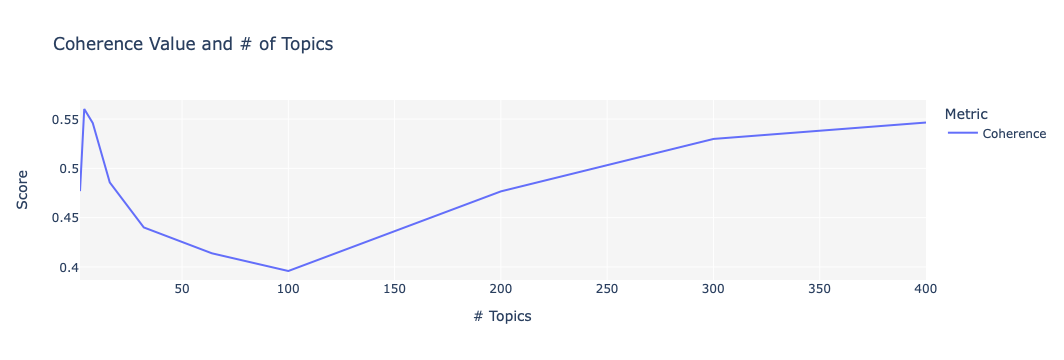

Best Model: Latent Dirichlet Allocation | # Topics: 4 | Coherence: 0.5602


In [104]:
outcome_tuning = tune_model(model = 'lda', multi_core = True)

## LDA with gensim, nltk
PyCaret is useful for EDA and limited scope NLP but is generally inflexible. For example, the only way to view the bigrams and trigrams by topic was through their interactive `evaluate_model` and then to paste in the images. We couldn't access this data in a dataframe format.

Given this limited flexibility of the PyCaret model, we built an LDA model with gensim.

The intention is to build on the EDA performed and build on what we learned about the performance of bigrams and trigrams versus individual words, and the approximately correct # of topics for inclusion, exclusion, and outcome.

### Data Cleaning & Preprocessing

In [105]:
def expand_contractions(text):
    contractions_dict = {"ain't": 'are not', "'s": ' is', "aren't": 'are not', "can't": 'cannot', "can't've": 'cannot have', "'cause": 'because', "could've": 'could have', "couldn't": 'could not', "couldn't've": 'could not have', "didn't": 'did not', "doesn't": 'does not', "don't": 'do not', "hadn't": 'had not', "hadn't've": 'had not have', "hasn't": 'has not', "haven't": 'have not', "he'd": 'he would', "he'd've": 'he would have', "he'll": 'he will', "he'll've": 'he will have', "how'd": 'how did', "how'd'y": 'how do you', "how'll": 'how will', "i'd": 'i would', "i'd've": 'i would have', "i'll": 'i will', "i'll've": 'i will have', "i'm": 'i am', "i've": 'i have', "isn't": 'is not', "it'd": 'it would', "it'd've": 'it would have', "it'll": 'it will', "it'll've": 'it will have', "let's": 'let us', "ma'am": 'madam', "mayn't": 'may not', "might've": 'might have', "mightn't": 'might not', "mightn't've": 'might not have', "must've": 'must have', "mustn't": 'must not', "mustn't've": 'must not have', "needn't": 'need not', "needn't've": 'need not have', "o'clock": 'of the clock', "oughtn't": 'ought not', "oughtn't've": 'ought not have', "shan't": 'shall not', "sha'n't": 'shall not', "shan't've": 'shall not have', "she'd": 'she would', "she'd've": 'she would have', "she'll": 'she will', "she'll've": 'she will have', "should've": 'should have', "shouldn't": 'should not', "shouldn't've": 'should not have', "so've": 'so have', "that'd": 'that would', "that'd've": 'that would have', "there'd": 'there would', "there'd've": 'there would have', "they'd": 'they would', "they'd've": 'they would have', "they'll": 'they will', "they'll've": 'they will have', "they're": 'they are', "they've": 'they have', "to've": 'to have', "wasn't": 'was not', "we'd": 'we would', "we'd've": 'we would have', "we'll": 'we will', "we'll've": 'we will have', "we're": 'we are', "we've": 'we have', "weren't": 'were not', "what'll": 'what will', "what'll've": 'what will have', "what're": 'what are', "what've": 'what have', "when've": 'when have', "where'd": 'where did', "where've": 'where have', "who'll": 'who will', "who'll've": 'who will have', "who've": 'who have', "why've": 'why have', "will've": 'will have', "won't": 'will not', "won't've": 'will not have', "would've": 'would have', "wouldn't": 'would not', "wouldn't've": 'would not have', "y'all": 'you all', "y'all'd": 'you all would', "y'all'd've": 'you all would have', "y'all're": 'you all are', "y'all've": 'you all have', "you'd": 'you would', "you'd've": 'you would have', "you'll": 'you will', "you'll've": 'you will have', "you're": 'you are', "you've": 'you have'}
    # Regular expression for finding contractions
    contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))
    def replace(match):
        return contractions_dict[match.group(0)]
    text = ' '.join([t.replace('’',"'") for t in text.split()])
    return contractions_re.sub(replace, text)

def data_preprocess(text):
    
    # make text lower case
    text = text.lower()
    
    # Apply expand_contractions (This will convert string like "isn't" into "is not")
    text = expand_contractions(text)
    
    text = text.replace('>','greater than').replace('<','less than')
    
    # Remove digits and alpha numeric words
    text = re.sub('\w*\d\w*','', text)
    
    # Remove punctuations
    #string.punctuation => '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'[^\w\s]',' ',text)
    
    # Remove extra space
    text = re.sub(' +',' ',text)
    
    text = text.split()
    
    # Remove stopwords 
    text = [word for word in text if word not in stopwords.words('english')]
    
    # Remove tokens if length is > 20 and length < 3
    text = [t for t in text if len(t)<=20 and len(t)>=3]
    
    # Lematize
    wl = WordNetLemmatizer()
    text = [wl.lemmatize(t) for t in text]
    
    text = ' '.join(text)
    
    return text

In [106]:
# generates id2word and corpus and inputs to LDA model
def topic_modelling(data):
    
    aux = data.copy()
    aux['tokens'] = aux['clean'].progress_apply(lambda x : x.split())
    
    # generate bigrams
    bigram = gensim.models.Phrases(aux['tokens'], min_count=5, threshold=1)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    aux['tokens_bigram'] = aux['tokens'].progress_map(lambda tokens : bigram_mod[tokens])
    
    # generate trigrams
    trigram = gensim.models.Phrases(bigram[aux['tokens']], threshold=100)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    aux['tokens_trigram'] = aux['tokens'].progress_map(lambda tokens : trigram_mod[tokens])

    id2word = corpora.Dictionary(aux['tokens_bigram'])
    texts = aux['tokens_bigram'].values
    corpus = [id2word.doc2bow(text) for text in texts]
    
    return aux,id2word,texts,corpus

# generates LDA model
def LDA_model(num_topics, id2word, corpus, passes=1):
    return gensim.models.ldamodel.LdaModel(corpus=tqdm_notebook(corpus, leave=False),
                                               id2word=id2word,
                                               num_topics=num_topics, 
                                               random_state=100,
                                               eval_every=10,
                                               chunksize=2000,
                                               passes=passes,
                                               per_word_topics=True
                                            )


# computes coherence for LDA model
def compute_coherence(model,id2word,aux):
    coherence = CoherenceModel(model=model, 
                           texts=aux['tokens_bigram'].values,
                           dictionary=id2word, coherence='c_v')
    return coherence.get_coherence()

# displays topics for LDA model
def display_topics(model):
    topics = model.show_topics(num_topics=model.num_topics, formatted=False, num_words=10)
    topics = map(lambda c: map(lambda cc: cc[0], c[1]), topics)
    df = pd.DataFrame(topics)
    df.index = ['topic_{0}'.format(i) for i in range(model.num_topics)]
    df.columns = ['keyword_{0}'.format(i) for i in range(1, 10+1)]
    return df

def explore_models(df, rg=range(5, 25)):
    id2word = corpora.Dictionary(df['tokens_bigram'])
    texts = df['tokens_bigram'].values
    corpus = [id2word.doc2bow(text) for text in texts]

    models = []
    coherences = []
    
    for num_topics in tqdm_notebook(rg, leave=False):
        lda_model = LDA_model(num_topics,id2word,corpus, passes=5)
        models.append(lda_model)
        coherence = compute_coherence(lda_model,id2word,df)
        coherences.append(coherence)
      
    fig = plt.figure(figsize=(15, 5))
    plt.title('Choosing the optimal number of topics')
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence')
    plt.grid(True)
    plt.plot(rg, coherences)
    return coherences, models

In [107]:
# create preprocessed data
inclusion['clean']=inclusion['criterion'].progress_apply(lambda x : data_preprocess(x))
exclusion['clean']=exclusion['criterion'].progress_apply(lambda x : data_preprocess(x))
outcome['clean']=outcome['description'].progress_apply(lambda x : data_preprocess(x))

  0%|          | 0/9126 [00:00<?, ?it/s]

  0%|          | 0/14675 [00:00<?, ?it/s]

  0%|          | 0/10699 [00:00<?, ?it/s]

In [108]:
inclusion_aux, inclusion_id2word, inclusion_texts, inclusion_corpus = topic_modelling(inclusion)
exclusion_aux, exclusion_id2word, exclusion_texts, exclusion_corpus = topic_modelling(exclusion)
outcome_aux, outcome_id2word, outcome_texts, outcome_corpus = topic_modelling(outcome)

  0%|          | 0/9126 [00:00<?, ?it/s]

  0%|          | 0/9126 [00:00<?, ?it/s]

  0%|          | 0/9126 [00:00<?, ?it/s]

  0%|          | 0/14675 [00:00<?, ?it/s]

  0%|          | 0/14675 [00:00<?, ?it/s]

  0%|          | 0/14675 [00:00<?, ?it/s]

  0%|          | 0/10699 [00:00<?, ?it/s]

  0%|          | 0/10699 [00:00<?, ?it/s]

  0%|          | 0/10699 [00:00<?, ?it/s]

### Inclusion

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/9126 [00:00<?, ?it/s]

  0%|          | 0/9126 [00:00<?, ?it/s]

  0%|          | 0/9126 [00:00<?, ?it/s]

  0%|          | 0/9126 [00:00<?, ?it/s]

  0%|          | 0/9126 [00:00<?, ?it/s]

  0%|          | 0/9126 [00:00<?, ?it/s]

  0%|          | 0/9126 [00:00<?, ?it/s]

  0%|          | 0/9126 [00:00<?, ?it/s]

  0%|          | 0/9126 [00:00<?, ?it/s]

  0%|          | 0/9126 [00:00<?, ?it/s]

  0%|          | 0/9126 [00:00<?, ?it/s]

  0%|          | 0/9126 [00:00<?, ?it/s]

  0%|          | 0/9126 [00:00<?, ?it/s]

  0%|          | 0/9126 [00:00<?, ?it/s]

  0%|          | 0/9126 [00:00<?, ?it/s]

  0%|          | 0/9126 [00:00<?, ?it/s]

  0%|          | 0/9126 [00:00<?, ?it/s]

  0%|          | 0/9126 [00:00<?, ?it/s]

  0%|          | 0/9126 [00:00<?, ?it/s]

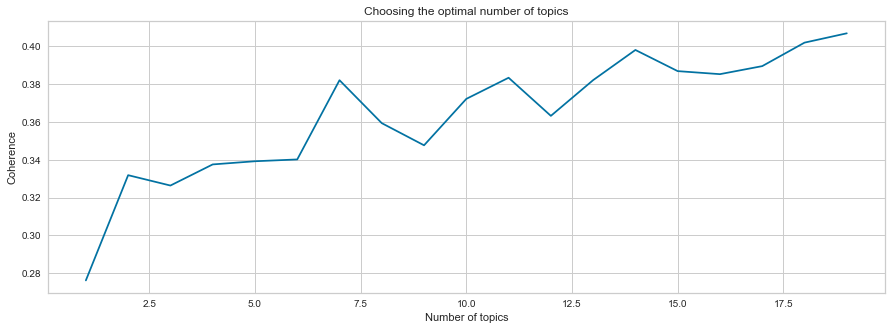

In [109]:
# looking at coherence values for 1 to 20 topics
inclusion_coherences, inclusion_models = explore_models(inclusion_aux, rg=range(1, 20, 1))

**Note** The plot supports what we saw with PyCaret that lower values of topics are better.

In [110]:
# creating initial model with 4 topics based on PyCaret EDA
inclusion_model = LDA_model(4,inclusion_id2word,inclusion_corpus, passes=5)

# map topics to each row
topics = []
for i in inclusion_model.get_document_topics(inclusion_corpus):
    topics.append('topic_'+str(i[0][0]))
inclusion['topics'] = topics

  0%|          | 0/9126 [00:00<?, ?it/s]

In [111]:
inclusion_lda_df = display_topics(model = inclusion_model)
inclusion_lda_df.head()

,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7,keyword_8,keyword_9,keyword_10
topic_0,age_year,study,month,pain,patient,year,greater,day,old,english
topic_1,age,patient,surgery,year_age,male_female,year_old,aged_year,american_society,older,body_mass
topic_2,patient,child,surgery,treatment,week,diagnosed,year,study,scale,health
topic_3,pain,informed_consent,patient,consent,subject,written_informed,participant,able,without,symptom


**Note** As was true with PyCaret, clusters/topics aren't clear from looking at individual words. We will develop LDA models with bigrams and trigrams next to improve our view.

### Exclusion

  0%|          | 0/14675 [00:00<?, ?it/s]

  0%|          | 0/14675 [00:00<?, ?it/s]

  0%|          | 0/14675 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/14675 [00:00<?, ?it/s]

  0%|          | 0/14675 [00:00<?, ?it/s]

  0%|          | 0/14675 [00:00<?, ?it/s]

  0%|          | 0/14675 [00:00<?, ?it/s]

  0%|          | 0/14675 [00:00<?, ?it/s]

  0%|          | 0/14675 [00:00<?, ?it/s]

  0%|          | 0/14675 [00:00<?, ?it/s]

  0%|          | 0/14675 [00:00<?, ?it/s]

  0%|          | 0/14675 [00:00<?, ?it/s]

  0%|          | 0/14675 [00:00<?, ?it/s]

  0%|          | 0/14675 [00:00<?, ?it/s]

  0%|          | 0/14675 [00:00<?, ?it/s]

  0%|          | 0/14675 [00:00<?, ?it/s]

  0%|          | 0/14675 [00:00<?, ?it/s]

  0%|          | 0/14675 [00:00<?, ?it/s]

  0%|          | 0/14675 [00:00<?, ?it/s]

  0%|          | 0/14675 [00:00<?, ?it/s]

  0%|          | 0/14675 [00:00<?, ?it/s]

  0%|          | 0/14675 [00:00<?, ?it/s]

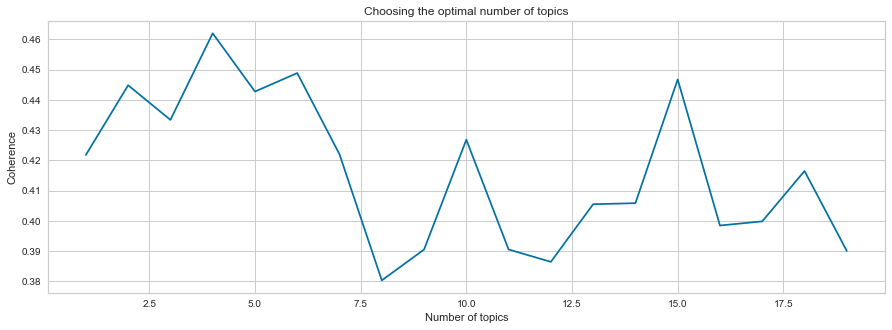

In [112]:
exclusion_aux,exclusion_id2word,exclusion_texts,exclusion_corpus = topic_modelling(exclusion)
exclusion_coherences, exclusion_models = explore_models(exclusion_aux, rg=range(1, 20, 1))

**Note** This supports what we saw with PyCaret. Similarly to what we see with the simpler modeling on PyCaret, more topics provide higher coherence in the case of the exclusion criteria.

In [113]:
# choosing 6 topics based on plot
exclusion_best_model = LDA_model(6, exclusion_id2word, exclusion_corpus, passes=5)

texts = exclusion_aux['tokens_bigram'].values

topics = []
for i in exclusion_best_model.get_document_topics(exclusion_corpus):
    topics.append('topic_'+str(i[0][0]))
    
exclusion['topics'] = topics

  0%|          | 0/14675 [00:00<?, ?it/s]

In [114]:
exclusion_lda_df = display_topics(model=exclusion_best_model)
exclusion_lda_df.head()

,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7,keyword_8,keyword_9,keyword_10
topic_0,study,child,surgery,patient,treatment,pain,use,woman,receipt,participant
topic_1,pregnancy,pregnant,patient,disease,participate_study,informed_consent,infection,participant,anesthetic,hearing
topic_2,disorder,patient,subject,abuse,study,consent,trial,condition,medication,investigator
topic_3,use,drug,allergy,study,medication,day,within_day,component,including,patient
topic_4,history,patient,disease,pain,syndrome,chronic_pain,chronic,greater,injury,diagnosis


**Note** Likewise, its hard to pull topics from this eyeballing it. 

### Outcomes

  0%|          | 0/10699 [00:00<?, ?it/s]

  0%|          | 0/10699 [00:00<?, ?it/s]

  0%|          | 0/10699 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/10699 [00:00<?, ?it/s]

  0%|          | 0/10699 [00:00<?, ?it/s]

  0%|          | 0/10699 [00:00<?, ?it/s]

  0%|          | 0/10699 [00:00<?, ?it/s]

  0%|          | 0/10699 [00:00<?, ?it/s]

  0%|          | 0/10699 [00:00<?, ?it/s]

  0%|          | 0/10699 [00:00<?, ?it/s]

  0%|          | 0/10699 [00:00<?, ?it/s]

  0%|          | 0/10699 [00:00<?, ?it/s]

  0%|          | 0/10699 [00:00<?, ?it/s]

  0%|          | 0/10699 [00:00<?, ?it/s]

  0%|          | 0/10699 [00:00<?, ?it/s]

  0%|          | 0/10699 [00:00<?, ?it/s]

  0%|          | 0/10699 [00:00<?, ?it/s]

  0%|          | 0/10699 [00:00<?, ?it/s]

  0%|          | 0/10699 [00:00<?, ?it/s]

  0%|          | 0/10699 [00:00<?, ?it/s]

  0%|          | 0/10699 [00:00<?, ?it/s]

  0%|          | 0/10699 [00:00<?, ?it/s]

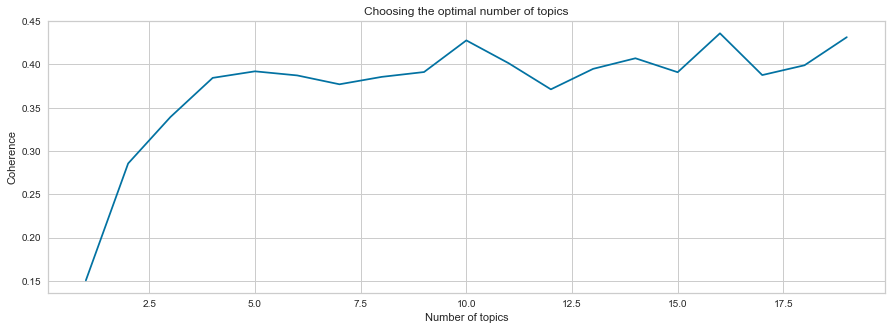

In [115]:
outcome_aux,outcome_id2word,outcome_texts,outcome_corpus = topic_modelling(outcome)
outcome_coherences, outcome_models = explore_models(outcome_aux, rg=range(1, 20, 1))

In [116]:
outcome_best_model = LDA_model(8, outcome_id2word, outcome_corpus, passes=5)

texts = outcome_aux['tokens_bigram'].values

topics = []
for i in outcome_best_model.get_document_topics(outcome_corpus):
    topics.append('topic_'+str(i[0][0]))
outcome['topics'] = topics

  0%|          | 0/10699 [00:00<?, ?it/s]

In [117]:
outcome_lda_df = display_topics(model=outcome_best_model)
outcome_lda_df.head()

,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7,keyword_8,keyword_9,keyword_10
topic_0,pain,scale,score,pain_intensity,point,visual_analog,patient,pain_worst,scale_va,rating_scale
topic_1,score,baseline,pain,participant,injection,session,time,time_point,treatment,pain_intensity
topic_2,time,test,patient,participant,measured,recorded,treatment,intervention,measurement,adverse_event
topic_3,pressure,change,scale,sleep,treatment,using,measured,impact,assessed,patient
topic_4,pain_relief,relief,participant,dose,measured,minute_heel,puncture_minute,heel_puncture,measure,respiratory_rate


**Discussion**

- Topics/clusters continue to be unclear. 
- We had better results using bigrams and trigrams in the PyCaret LDA.
- Gensim LDA incorporates bigrams and trigrams but these aren't included in the top words because their frequency is less than unigrams.
- Therefore we next develop an LDA model that only runs on bigrams and only runs on trigrams (no unigrams included at all).

## Testing LDA with only bigrams or trigrams 

- Interest is to get more meaningful clusters (i.e., where we can eyeball and recognize what the criteria is, which may require more than a collection of unigrams).

- Using optimal `num_topics` as found with PyCaret.

### Writings functions to take in only bigrams or trigrams

In [118]:
inclusion_ngram = pd.read_csv('./inclusion/Pain.txt',sep='\t')
exclusion_ngram = pd.read_csv('./exclusion/Pain.txt',sep='\t')
outcome_ngram = pd.read_csv('./outcome/Pain.txt',sep='\t')
outcome_ngram = outcome[~outcome['description'].isna()]

In [119]:
# create preprocessed data
inclusion_ngram['clean']=inclusion_ngram['criterion'].progress_apply(lambda x : data_preprocess(x))
exclusion_ngram['clean']=exclusion_ngram['criterion'].progress_apply(lambda x : data_preprocess(x))
outcome_ngram['clean']=outcome_ngram['description'].progress_apply(lambda x : data_preprocess(x))

  0%|          | 0/9126 [00:00<?, ?it/s]

  0%|          | 0/14675 [00:00<?, ?it/s]

  0%|          | 0/10699 [00:00<?, ?it/s]

In [120]:
from nltk.util import ngrams

# generates id2word and corpus and inputs to LDA model
def topic_modelling_ngram(data, ngram=2):
    aux = data.copy()
    aux['tokens'] = aux['clean'].progress_apply(lambda x : x.split())
    
    # ngrams (n = 2 or n = 3)
    ngrams_col = []
    for i, j in aux.iterrows():
        ngrams_col.append(["_".join(w) for w in ngrams(j['clean'].split(), ngram)])

    aux[str(ngram) + 'ngrams'] = ngrams_col

    id2word = corpora.Dictionary(aux[str(ngram) + 'ngrams'])
    texts = aux[str(ngram) + 'ngrams'].values
    corpus = [id2word.doc2bow(text) for text in texts]
    
    return aux,id2word,texts,corpus

# displays topics for LDA model
def display_topics(model):
    topics = model.show_topics(num_topics=model.num_topics, formatted=False, num_words=10)
    topics = map(lambda c: map(lambda cc: cc[0], c[1]), topics)
    df = pd.DataFrame(topics)
    df.index = ['topic_{0}'.format(i) for i in range(model.num_topics)]
    df.columns = ['keyword_{0}'.format(i) for i in range(1, 10+1)]
    return df

# generates LDA model
def LDA_model(num_topics, id2word, corpus, passes):
    return gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           eval_every=1,
                                           alpha='auto',
                                           chunksize=10,
                                           passes=passes,
                                           per_word_topics=True
                                            )

In [121]:
# with bigrams
inclusion_aux_bi, inclusion_id2word_bi, inclusion_texts_bi, inclusion_corpus_bi = topic_modelling_ngram(inclusion, 2)
exclusion_aux_bi, exclusion_id2word_bi, exclusion_texts_bi, exclusion_corpus_bi = topic_modelling_ngram(exclusion, 2)
outcome_aux_bi, outcome_id2word_bi, outcome_texts_bi, outcome_corpus_bi = topic_modelling_ngram(outcome, 2)

# with trigrams
inclusion_aux_tri, inclusion_id2word_tri, inclusion_texts_tri, inclusion_corpus_tri = topic_modelling_ngram(inclusion, 3)
exclusion_aux_tri, exclusion_id2word_tri, exclusion_texts_tri, exclusion_corpus_tri = topic_modelling_ngram(exclusion, 3)
outcome_aux_tri, outcome_id2word_tri, outcome_texts_tri, outcome_corpus_tri = topic_modelling_ngram(outcome, 3)

  0%|          | 0/9126 [00:00<?, ?it/s]

  0%|          | 0/14675 [00:00<?, ?it/s]

  0%|          | 0/10699 [00:00<?, ?it/s]

  0%|          | 0/9126 [00:00<?, ?it/s]

  0%|          | 0/14675 [00:00<?, ?it/s]

  0%|          | 0/10699 [00:00<?, ?it/s]

### Inclusion

**Note** 

- A key difference in the below LDA models is they were trained on ONLY bigrams or trigrams. The PyCaret model was trained on unigrams, bigrams, and trigrams, AND THEN we showed topics in terms of only bigrams or trigrams.
- We weren't able to figure out how to perform that kind of training and visualization using gensim.

In [122]:
# creating initial model with 4 topics based on PyCaret EDA
bigram_inclusion_model = LDA_model(4,inclusion_id2word_bi,inclusion_corpus_bi, passes=5)

# map topics to each row
topics = []
for i in bigram_inclusion_model.get_document_topics(inclusion_corpus_bi):
    topics.append('bigram_topic_'+str(i[0][0]))
inclusion_ngram['bigram_topics'] = topics

display_topics(model=bigram_inclusion_model)

,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7,keyword_8,keyword_9,keyword_10
topic_0,year_old,male_female,patient_must,laboratory_test,least_one,patient_least,patient_undergoing,adult_patient,gestational_age,general_anesthesia
topic_1,chronic_pain,score_greater,least_month,rating_scale,greater_month,past_month,self_reported,pain_score,least_hour,pain_intensity
topic_2,year_age,study_procedure,aged_year,chest_tube,patient_year,able_understand,comply_study,clinic_visit,six_month,age_older
topic_3,informed_consent,age_year,consent_form,written_informed,participate_study,provide_written,written_consent,willing_participate,willing_provide,least_year


Topics appear to be:
- age
- pain of some length and intensity
- ability to comply with the study
- consent and willingness

In [123]:
# same but with trigrams
trigram_inclusion_model = LDA_model(4,inclusion_id2word_tri,inclusion_corpus_tri, passes=5)

topics = []
for i in trigram_inclusion_model.get_document_topics(inclusion_corpus_tri):
    topics.append('trigram_topic_'+str(i[0][0]))
inclusion_ngram['trigram_topics'] = topics

display_topics(model=trigram_inclusion_model)

,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7,keyword_8,keyword_9,keyword_10
topic_0,asa_physical_status,body_mass_index,mass_index_bmi,receiving_medical_treatment,american_society_anesthesiologist,patient_written_consent,pain_past_month,gestational_age_week,clinically_significant_abnormality,physical_status_iii
topic_1,least_year_old,entire_study_period,childbearing_potential_must,randomisation_defined_required,analgesia_randomisation_defined,analgesic_treatment_previous,defined_required_change,change_analgesic_treatment,stable_analgesia_randomisation,treatment_previous_day
topic_2,written_informed_consent,informed_consent_form,provide_written_informed,willing_provide_written,age_year_old,signing_informed_consent,give_informed_consent,consent_form_icf,comply_study_procedure,able_willing_provide
topic_3,aged_year_old,numeric_rating_scale,social_security_system,affiliated_social_security,pain_greater_month,visual_analog_scale,chest_tube_inserted,coronary_angiography_performed,point_numeric_rating,intensity_score_greater


Topics are less clear. We will ignore those generated for trigrams.

**Discussion**
- Bigram topics seem to be clearer than trigram topics
- Inclusion criteria based on bigrams seem to be: age, pain of some intensity and length, ability to comply, consent

### Exclusion

In [124]:
bigram_exclusion_model = LDA_model(8, exclusion_id2word_bi, exclusion_corpus_bi, passes = 5)

topics = []
for i in bigram_exclusion_model.get_document_topics(exclusion_corpus_bi):
    topics.append('bigram_topic_'+str(i[0][0]))
exclusion_ngram['bigram_topics'] = topics

display_topics(model=bigram_exclusion_model)

,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7,keyword_8,keyword_9,keyword_10
topic_0,within_day,past_month,within_past,substance_use,psychiatric_disorder,within_hour,alcohol_drug,allergic_reaction,use_disorder,drug_abuse
topic_1,week_prior,within_week,within_last,bipolar_disorder,admission_unit,informed_consent,exclusion_criterion,till_admission,screening_till,rheumatoid_arthritis
topic_2,hcv_rna,hepatitis_hbc,known_hcv,known_hbv,infection_hbsag,inactive_chronic,hepatitis_hbv,le_persistently,hbv_hbc,hbv_dna
topic_3,opioid_use,heart_failure,bowel_disease,inflammatory_bowel,congestive_heart,fraction_le,ejection_fraction,acute_myocardial,liver_disease,angina_pectoris
topic_4,unstable_vital,traumatic_chest,acetaminophen_morphine,hospitalization_chronic,extensive_hospitalization,based_skin,respiration_le,sign_systolic,contraindicated_require,status_presenting
topic_5,unstable_vital,traumatic_chest,acetaminophen_morphine,hospitalization_chronic,extensive_hospitalization,based_skin,respiration_le,sign_systolic,contraindicated_require,status_presenting
topic_6,serum_creatinine,time_upper,upper_limit,limit_normal,creatinine_greater,greater_time,bilirubin_greater,abnormal_liver,normal_uln,total_bilirubin
topic_7,within_month,chronic_pain,covid_vaccine,month_prior,opinion_investigator,participate_study,known_hypersensitivity,surgical_procedure,clinical_trial,inpatient_outpatient


Topics / exclusion clusters are not clear.

In [125]:
trigram_exclusion_model = LDA_model(8, exclusion_id2word_tri, exclusion_corpus_tri, passes=5)

topics = []
for i in trigram_exclusion_model.get_document_topics(exclusion_corpus_tri):
    topics.append('trigram_topic_'+str(i[0][0]))
exclusion_ngram['trigram_topics'] = topics

display_topics(model=trigram_exclusion_model)

,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7,keyword_8,keyword_9,keyword_10
topic_0,unwilling_unable_comply,tobacco_nicotine_containing,comply_lifestyle_consideration,participant_unwilling_unable,unable_comply_lifestyle,use_tobacco_nicotine,prior_safety_laboratory,safety_laboratory_evaluation,throughout_entire_study,final_study_visit
topic_1,suicide_attempt_psychiatric,attempt_psychiatric_hospitalization,psychiatric_hospitalization_past,hospitalization_past_year,monthly_average_past,opioids_oud_current,month_planned_next,month_pregnant_trying,nicotine_opioids_oud,opinion_investigator_study
topic_2,within_day_prior,drug_within_day,research_study_personnel,investigational_drug_within,stable_absence_therapy,may_included_previous,skin_cancer_prostate,surgical_excision_chemotherapy,excision_chemotherapy_radiation,estimation_provides_reasonable
topic_3,upper_limit_normal,greater_time_upper,time_upper_limit,body_mass_index,alt_greater_time,limit_normal_value,mass_index_bmi,current_previous_allergy,allergy_allergic_response,previous_allergy_allergic
topic_4,local_anesthetic_amide,anesthetic_amide_type,active_disease_infection,skin_cancer_treatment,history_multiple_severe,amide_type_history,severe_allergy_history,allergy_history_anaphylactic,significant_alcohol_drug,allergic_reaction_component
topic_5,patient_excluded_study,exclusion_criterion_include,blood_pressure_mmhg,patient_presence_uncontrolled,potential_confound_trial,patient_must_take,patient_presence_active,patient_presence_neuropathy,oxidase_inhibitor_antidepressant,pectoris_myocardial_infarction
topic_6,becoming_pregnant_next,study_bipolar_disorder,next_month_childbearing,month_childbearing_year,control_unwilling_undergo,childbearing_year_unwilling,birth_control_unwilling,pregnant_next_month,accepted_form_birth,psychiatric_cognitive_disorder
topic_7,within_week_prior,within_past_month,within_month_prior,opinion_investigator_may,anti_inflammatory_drug,week_prior_enrollment,vaccine_within_week,condition_opinion_investigator,alcohol_drug_abuse,inflammatory_drug_nsaid


Topics / exclustion clusters are not clear.

### Outcome

In [126]:
bigram_outcome_model = LDA_model(8, outcome_id2word_bi, outcome_corpus_bi, passes = 5)

topics = []
for i in bigram_outcome_model.get_document_topics(outcome_corpus_bi):
    topics.append('bigram_topic_'+str(i[0][0]))
outcome_ngram['bigram_topics'] = topics

display_topics(model=bigram_outcome_model)

,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7,keyword_8,keyword_9,keyword_10
topic_0,flexion_rotation,lateral_flexion,two_independent,instrument_contains,head_position,neck_lateral,cervical_range,individual_error,connected_frame,measure_rotational
topic_1,adverse_event,number_percentage,much_improved,percentage_participant,participant_rate,agitation_sedation,sedation_level,event_adverse,related_adverse,improved_much
topic_2,first_treatment,measured_using,post_first,pain_relief,treatment_month,prior_first,treatment_measured,complete_relief,relief_using,relief_complete
topic_3,rating_scale,pain_intensity,pain_worst,visual_analog,analog_scale,pain_imaginable,numerical_rating,collected_pain,greater_pain,visual_analogue
topic_4,pain_score,total_score,self_reported,heel_puncture,minute_heel,point_scale,heart_rate,scale_pain,pain_scale,pain_level
topic_5,mean_pain,score_pain,pain_mean,pain_severity,back_neck,plasma_concentration,pain_following,dose_level,calculation_conducted,single_repeated
topic_6,higher_score,score_range,range_higher,score_indicating,worst_pain,facial_expression,score_indicates,numeric_rating,severe_pain,number_day
topic_7,magnetic_resonance,imaging_mri,resonance_imaging,placebo_administration,functional_magnetic,connectivity_evaluated,device_patient,neuroanatomy_measurement,using_magnetic,measurement_assessed


In [127]:
trigram_outcome_model = LDA_model(8, outcome_id2word_tri, outcome_corpus_tri, passes=5)

topics = []
for i in trigram_outcome_model.get_document_topics(outcome_corpus_tri):
    topics.append('trigram_topic_'+str(i[0][0]))
outcome_ngram['trigram_topics'] = topics

display_topics(model=trigram_outcome_model)

,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7,keyword_8,keyword_9,keyword_10
topic_0,pain_pressure_threshold,middle_distal_phalanx,distal_phalanx_thumb,resonance_imaging_mri,magnetic_resonance_imaging,self_administered_questionnaire,pressure_threshold_measured,functional_magnetic_resonance,using_magnetic_resonance,measurement_assessed_using
topic_1,numeric_rating_scale,numerical_rating_scale,pain_worst_pain,rating_scale_nrs,rating_scale_pain,using_numerical_rating,pain_relief_using,relief_complete_relief,relief_little_relief,relief_lot_relief
topic_2,point_higher_score,scale_minimum_maximum,higher_score_mean,score_mean_worse,mean_worse_outcome,unabbreviated_scale_title,minimum_maximum_value,moderate_severe_severe,severe_depression_respectively,severe_severe_depression
topic_3,self_reported_pain,face_leg_activity,leg_activity_cry,pain_catastrophizing_scale,pain_score_zero,activity_cry_consolability,pain_score_scale,higher_rating_indicate,score_indicate_better,score_indicating_pain
topic_4,minute_heel_puncture,worst_pain_imaginable,puncture_minute_heel,heel_puncture_minute,higher_score_indicates,rate_minute_heel,point_scale_ranging,state_trait_anxiety,infant_pain_scale,neonatal_infant_pain
topic_5,range_higher_score,higher_score_indicating,change_self_reported,score_range_higher,prior_first_treatment,month_post_first,treatment_month_post,first_treatment_month,post_first_treatment,first_treatment_measured
topic_6,visual_analog_scale,analog_scale_va,pain_score_assessed,pain_visual_analog,anxiety_severe_anxiety,scale_item_ranging,item_ranging_indicating,single_likert_scale,likert_scale_item,visual_analog_score
topic_7,score_indicating_greater,pain_severe_pain,visual_analogue_scale,pain_rating_scale,worst_imaginable_pain,pain_worst_imaginable,mean_pain_mean,score_indicates_greater,brief_pain_inventory,analogue_scale_va


Topics / outcome clsuters are not clear.

**Discussion**
- Generating LDA models with only bigrams or trigrams failed.
- We weren't able to get the results we got with PyCaret.
- We suspect this is because the LDA models in PyCaret were generated with unigrams, bigrams, and trigrams, AND after the model was built, we had success looking at the topic bigrams or trigrams. Here, we only trained on one type of ngram to then look at it.
- We next try standard clustering with kmeans to see what topics we can find for inclusion, exclusion, and outcome.

## K means

In [128]:
def tfidf_vectorization(data):
    vectorizer = TfidfVectorizer(min_df=5, analyzer='word', ngram_range=(1, 2), stop_words='english')
    vz = vectorizer.fit_transform(data['clean'])
    tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
    tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
    tfidf.columns = ['tfidf']
    return vectorizer,vz,tfidf

In [129]:
inclusion_vectorizer,inclusion_vector,inclusion_tfidf =  tfidf_vectorization(inclusion)
exclusion_vectorizer,exclusion_vector,exclusion_tfidf =  tfidf_vectorization(exclusion)
outcome_vectorizer,outcome_vector,outcome_tfidf =  tfidf_vectorization(outcome)

In [130]:
def find_optimal_cluster(vz,max_cluster=20):
    distortions = []
    sil_scores = []
    for k in range(2,max_cluster):
        kmeans_model = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=1, random_state=42, init_size=1000, verbose=False, max_iter=1000)
        kmeans_model.fit(vz)
        sil_score = silhouette_score(vz, kmeans_model.labels_)
        sil_scores.append(sil_score)
        distortions.append(kmeans_model.inertia_)
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 10))

    ax1.plot(range(2, max_cluster), distortions)
    ax1.set_title('Distortion vs num of clusters')
    ax1.grid(True)

    ax2.plot(range(2, max_cluster), sil_scores)
    ax2.set_title('Silhouette score vs num of clusters')
    ax2.grid(True)

def apply_kmean(vz,n_clusters,vectorizer):
    
    # apply kmean clustering on vz
    kmeans = KMeans(n_clusters=n_clusters, max_iter=1000).fit(vz)
    
    # find the centroid of each cluster
    sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    all_keywords = []
    for i in range(n_clusters):
        topic_keywords = []
        for j in sorted_centroids[i, :10]:
            topic_keywords.append(terms[j])
        all_keywords.append(topic_keywords)

    keywords_df = pd.DataFrame(index=['topic_{0}'.format(i) for i in range(n_clusters)], 
                               columns=['keyword_{0}'.format(i) for i in range(10)],
                               data=all_keywords)
    
    
    return kmeans.labels_,keywords_df,kmeans

### Inclusion

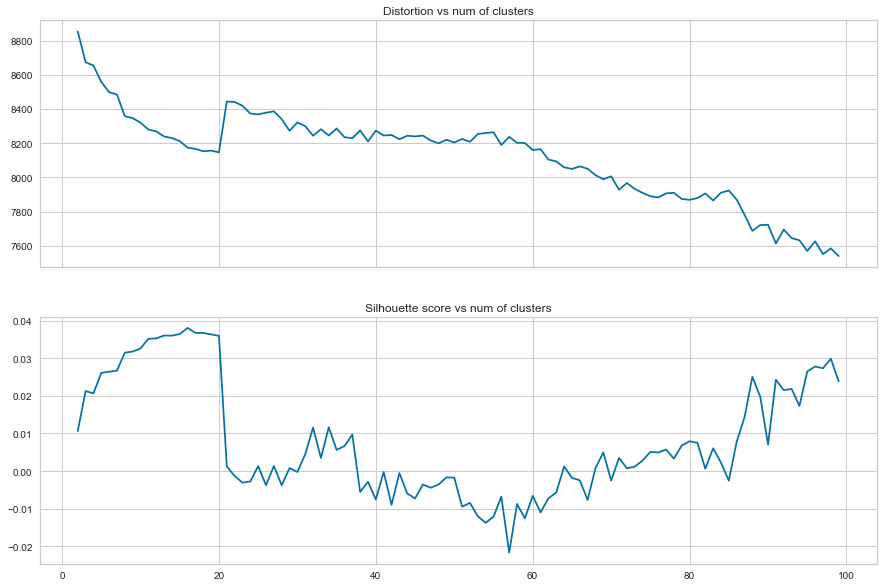

In [131]:
# create elbow and silhouette plots
find_optimal_cluster(inclusion_vector,max_cluster=100)

In [132]:
inclusion['label'],inclusion_kmeans_df,inclusion_kmean=apply_kmean(inclusion_vector,17,inclusion_vectorizer)

Elbow at 17 or so topics.

In [133]:
inclusion_kmeans_df

,keyword_0,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7,keyword_8,keyword_9
topic_0,bmi,body,body mass,mass,mass index,index,index bmi,bmi le,le,weight
topic_1,week,gestational,gestational age,week prior,gestation,prior,age,week gestation,age week,week gestational
topic_2,age,year age,year,age greater,greater,greater year,patient year,patient,le year,age inclusive
topic_3,pain,scale,score,greater,chronic,moderate,intensity,score greater,severe,va
topic_4,aged,aged year,year,patient aged,patient,older,year older,woman aged,child aged,woman
topic_5,cancer,treatment,opioid,pain,therapy,patient,day,diagnosis,dose,analgesic
topic_6,english,speaking,english speaking,read,able,speak,able read,understand,fluent,fluent english
topic_7,surgery,healthy,subject,child,pregnancy,diagnosis,woman,elective,le,scheduled
topic_8,consent,informed,informed consent,written,written informed,signed,provide,signed informed,able,study
topic_9,month,pain,expectancy,life expectancy,greater month,past month,life,pain month,past,greater


Inclusion criteria clusters are:
- undergoing elective surgery
- treatment history
- bmi
- consent
- age (shows up in 4-5 topics)
- undergoing procedure
- american
- pain of some length and intensity
- not pregnant
- english speaking (shows up in 2-3 topics)
- good life expectancy
- undergoing some treatment
- able to comply with study

Overall, out of 17 topics, we get 12-13 clear topics.

### Exclusion

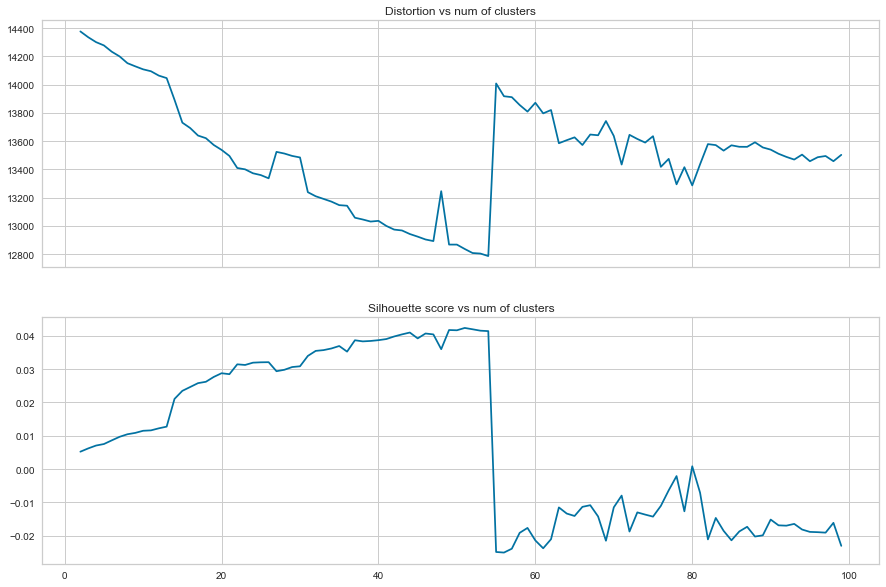

In [134]:
find_optimal_cluster(exclusion_vector,max_cluster=100)

In [135]:
exclusion['label'],exclusion_kmeans_df,exclusion_kmean=apply_kmean(exclusion_vector,20,exclusion_vectorizer)

This plot is harder to read but we go with 20 topics.

In [136]:
exclusion_kmeans_df

,keyword_0,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7,keyword_8,keyword_9
topic_0,age,year,age le,le,le year,age year,year age,year old,old,greater year
topic_1,consent,informed,informed consent,provide,unable,inability,provide informed,patient,refusal,written
topic_2,disease,history,liver,chronic,cardiovascular,heart,liver disease,severe,cardiovascular disease,psychiatric disease
topic_3,disorder,psychiatric,psychiatric disorder,seizure,seizure disorder,history,diagnosis,psychotic,bipolar,history seizure
topic_4,chronic pain,chronic,pain,history chronic,pain condition,pain syndrome,syndrome,history,condition,patient
topic_5,history,pain,greater,treatment,infection,contraindication,severe,active,condition,month
topic_6,pregnancy,lactation,pregnancy lactation,pregnancy breastfeeding,breastfeeding,current pregnancy,current,known,pregnancy test,multiple
topic_7,le,le month,life expectancy,expectancy,expectancy le,month,life,weight,weight le,min
topic_8,lactating,pregnant lactating,pregnant,female,lactating woman,woman,female pregnant,patient pregnant,pregnancy,planning
topic_9,pregnant,woman,pregnant woman,pregnant breastfeeding,breastfeeding,pregnant nursing,nursing,pregnant patient,patient,female


Exclusion criteria clusters:
- severe pain, chronic pain (2-3 topics)
- cardiovascular disease
- opinion of investigator
- pregnant (2-3 topics)
- history of seizure or epilepsy
- opioid use
- age
- hepatic function
- allergy
- anesthesia
- surgery or something else in prior month
- alcohol abuse
- heart failure
- lack of consent
- no english

16 or so clear topics out of 20.

### Outcome

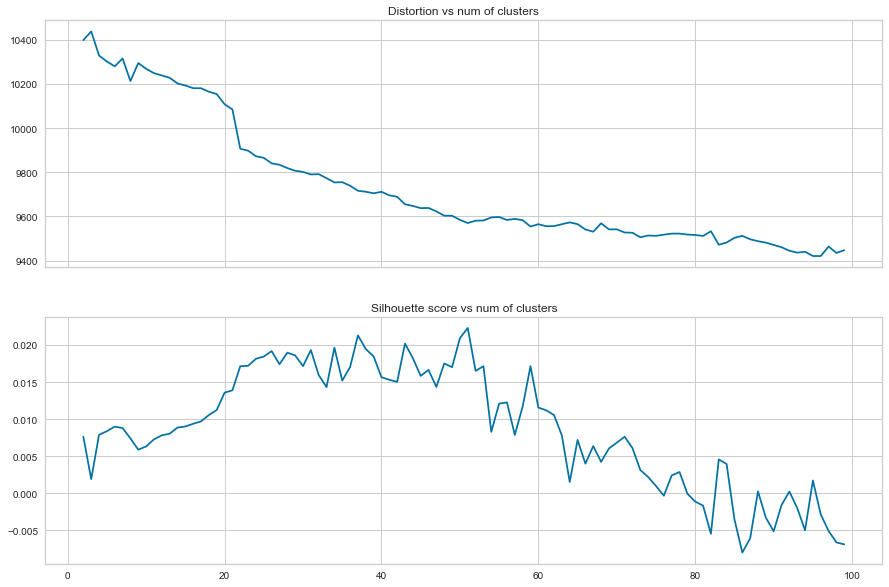

In [137]:
find_optimal_cluster(outcome_vector,max_cluster=100)

In [138]:
outcome['label'],outcome_kmeans_df,outcome_kmean=apply_kmean(outcome_vector,17,outcome_vectorizer)

We go with 17 topics, right before the high dip in the elbow plot.

In [139]:
outcome_kmeans_df

,keyword_0,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7,keyword_8,keyword_9
topic_0,time,measured,day,scale,participant,rate,using,minute,assessed,change
topic_1,analog,visual analog,analog scale,visual,pain,va,scale,scale va,worst,score
topic_2,nausea,vomiting,nausea vomiting,pruritus,dizziness,effect,vomiting pruritus,sedation,incidence nausea,incidence
topic_3,analogue,visual analogue,analogue scale,visual,pain,scale,va,scale va,using visual,score
topic_4,health,quality life,life,quality,questionnaire,physical,problem,score,function,functioning
topic_5,pain,rating,rating scale,scale,nrs,numeric,numeric rating,scale nrs,numerical rating,numerical
topic_6,score,higher,item,higher score,scale,pain,range,total,symptom,score range
topic_7,pressure,blood,concentration,blood pressure,plasma,sample,plasma concentration,time,systolic,blood sample
topic_8,patient,event,adverse,adverse event,treatment,number,study,satisfaction,reported,effect
topic_9,pain,score,scale,pain score,va,pain scale,severity,patient,using,pain inventory


Outcome clusters appear to be:
- blood pressure
- complete pain relief
- pain on some rating scale
- pain some visual analog scale
- questionnaire measure
- pain intensity measure
- adverse event
- moprhine consumption
- nausea, vomiting
- plasma concentration (of what?)
- sleep quality
- life quality
- anxiety, deression
- satisfcation
- heart rate
- physical function

16 or so clear clusters from 17.


In [140]:
inclusion.to_csv('output/inclusion_pain_label.csv',index=False)
exclusion.to_csv('output/exclusion_pain_label.csv',index=False)
outcome.to_csv('output/outcome_pain_label.csv',index=False)

**Discussion**
- We see by simply looking at the topics and their words that kmeans produces far better clusters than LDA. There are more and more clear clusters.
- That said, we will next compare results between LDA and kmeans using cosine similarity among the words in any one topic.
- Specifically, we will compare the LDA results where we don't just use bigrams or trigrams.

## Testing approaches

We see (by looking at the words that compose the topics) that kmeans provides more cohesive clusters/topics than LDA. However, we try to show this using cosine similarity too.

The idea is to compare the average cosine similarity score for each model. The average will be an average of the cosine similarities for each topic (so looking at how related are the words in each topic with LDA or cluster with kmeans).

Our method is:
- train a word2vec models on the corpus with inclusion, exclusion, and outcome csvs
- get a cosine similarity score using the word2vec embeddings for each topic in LDA and for each cluster in kmeans
- average and compare the cosine simarities for LDA and for kmeans across topics/clusters

In [141]:
from statistics import mean

# train model on tokens 
def word2vec(df):
    return Word2Vec(df['tokens_bigram'])

# get similarity for a list(row) of words
def similarity(df_list, model):
    pairwise_similarities = []
    
    # iterate through all pairs in list
    for i in range(len(df_list)):
        for j in range(len(df_list)):
            pairwise_similarities.append(model.similarity(df_list[i],df_list[j]))
            
    return mean(pairwise_similarities)

# plot and return average similarity for the model (e.g., kmeans on inclusion csv)
def test_model(df, model, model_name, data_subset):
    row_similarities = []
    
    df_list = df.values.tolist()
    # iterate through rows(topics) in dataframe
    for row in range(len(df_list)):
        row_similarities.append(similarity(row, model))
        
    # plot similarity score for each topic
    fig = plt.figure(figsize=(15, 5))
    plt.title(model_name + ' cosine similarity scores by topic for ' + data_subset)
    plt.xlabel('Topic')
    plt.ylabel('Similarity')
    plt.grid(True)
    plt.plot(df.index, row_similarities)
        
    return mean(row_similarities)

In [142]:
concat_df = pd.concat([inclusion_aux['tokens_bigram'], exclusion_aux['tokens_bigram'], outcome_aux['tokens_bigram']])
concat_model = Word2Vec(concat_df)

In [143]:
# testing whether the approach works
print("similarity between 'consent' and 'informed':", concat_model.similarity("consent", "informed"))
print("similarity between 'consent' and 'body mass':", concat_model.similarity("consent", "body_mass"))

similarity between 'consent' and 'informed': 0.9295739
similarity between 'consent' and 'body mass': 0.896587


Unfortunetly, training the word2vec model on the tokens in this dataset doesn't produce good results with cosine similarity. The words 'consent' and 'informed' should be more similar than 'consent' and 'seizure', but this is not the case. We saw these results with other pairings. Therefore we next try a pretrained word2vec model.

In [144]:
# grab pretrained model from Google
from gensim.models import KeyedVectors
filename = 'GoogleNews-vectors-negative300.bin'
model = KeyedVectors.load_word2vec_format(filename, binary=True)

In [145]:
# we see if a pretrained word2vec model performs better
print("similarity between 'consent' and 'informed':", model.similarity("consent", "informed"))
print("similarity between 'consent' and 'seizure':", model.similarity("consent", "seizure"))

similarity between 'consent' and 'informed': 0.28645268
similarity between 'consent' and 'seizure': 0.19868146


The pretrained model performs better. Words we expect to be more similar are indeed more similar. The problem with this model however is that certain bigrams may not exist, which are included in our keywords for the topics. 

The problem is that when we tried this on our keywords, the bigrams and trigrams weren't recognized so we can't run `similarity()` on our corpus. And, we can't update this Google model with vectors of the words in our corpus because its stored in a different state that can't be updated for efficiency purposes. Instead we download a large dataset from gensim and "pre-train" a new model and update with our corpus.

In [146]:
corpus = api.load('wiki-english-20171001')

In [147]:
model = Word2Vec(corpus)

In [148]:
model.save("word2vec.model")

In [149]:
model = gensim.models.Word2Vec.load("word2vec.model")
data = model.build_vocab(concat_df, update=True)

In [150]:
print("similarity between 'blue' and 'color':", model.similarity("blue", "color"))
print("similarity between 'consent' and 'balloon':", model.similarity("consent", "balloon"))

similarity between 'blue' and 'color': 0.101758294
similarity between 'consent' and 'balloon': 0.14627936


Despite using a different model (pre trained from gensim), the model doesn't work on the most basic example, such as here. 

We abandon using word2vec but include the code as it was something we tried.

### Applying kmeans to COVID

In [151]:
inclusion_covid = pd.read_csv('./COVID/inclusion/COVID-19.txt',sep='\t')
exclusion_covid = pd.read_csv('./COVID/exclusion/COVID-19.txt',sep='\t')
outcome_covid = pd.read_csv('./COVID/outcome/COVID-19.txt',sep='\t')
outcome_covid= outcome_covid[~outcome_covid['description'].isna()]

In [152]:
inclusion_covid['clean']=inclusion_covid['criterion'].progress_apply(lambda x : data_preprocess(x))
exclusion_covid['clean']=exclusion_covid['criterion'].progress_apply(lambda x : data_preprocess(x))
outcome_covid['clean']=outcome_covid['description'].progress_apply(lambda x : data_preprocess(x))

  0%|          | 0/7909 [00:00<?, ?it/s]

  0%|          | 0/11835 [00:00<?, ?it/s]

  0%|          | 0/15199 [00:00<?, ?it/s]

In [153]:
inclusion_vectorizer_covid,inclusion_vector_covid,inclusion_tfidf_covid = tfidf_vectorization(inclusion_covid)
exclusion_vectorizer_covid,exclusion_vector_covid,exclusion_tfidf_covid = tfidf_vectorization(exclusion_covid)
outcome_vectorizer_covid,outcome_vector_covid,outcome_tfidf_covid = tfidf_vectorization(outcome_covid)

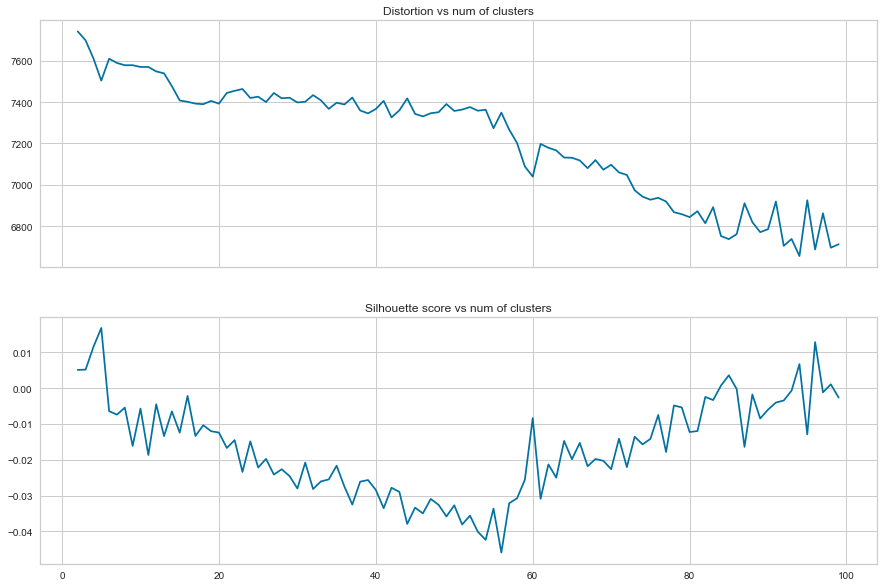

In [154]:
find_optimal_cluster(inclusion_vector_covid,max_cluster=100)

We go with 17 topics around where we have an elbow.

In [155]:
inclusion_covid['label'],inclusion_keyword_df_covid,inclusion_kmean_covid=apply_kmean(inclusion_vector_covid,17,inclusion_vectorizer_covid)

In [156]:
inclusion_keyword_df_covid

,keyword_0,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7,keyword_8,keyword_9
topic_0,le,respiratory,rate,respiratory rate,failure,min,respiratory failure,greater,minute,severe
topic_1,consent,informed,informed consent,signed,provide,able,written,signed informed,written informed,provide informed
topic_2,greater,day,symptom,cough,english,chest,able,fever,following,diabetes
topic_3,patient,hospitalized,ventilation,covid,mechanical,mechanical ventilation,invasive,hospitalized patient,covid patient,criterion
topic_4,oxygen,saturation,oxygen saturation,air,room air,room,supplemental,supplemental oxygen,le,requiring
topic_5,covid,pcr,positive,confirmed,diagnosis,symptom,test,covid infection,infection,covid positive
topic_6,year,year age,age,older,aged,aged year,age older,year older,adult,adult year
topic_7,age year,age,year,year older,older,patient age,adult age,year time,adult,time consent
topic_8,sars,cov,sars cov,infection,pcr,cov infection,positive,confirmed,test,positive sars
topic_9,hospital,care,admitted,health,medical,unit,intensive,intensive care,worker,patient


Inclusion topic clusters appear to be:
- chronic cardiovascular disease
- consent (appears 2-4 times)
- age (appears 2-4 times)
- positive pcr test
- symptoms of covid (cough, core throat)
- bmi
- oxygen saturation
- childbearing potential
- sars cov infection
- male or female
- on ventilation; in intensive care

11 solid clusters out of 17.

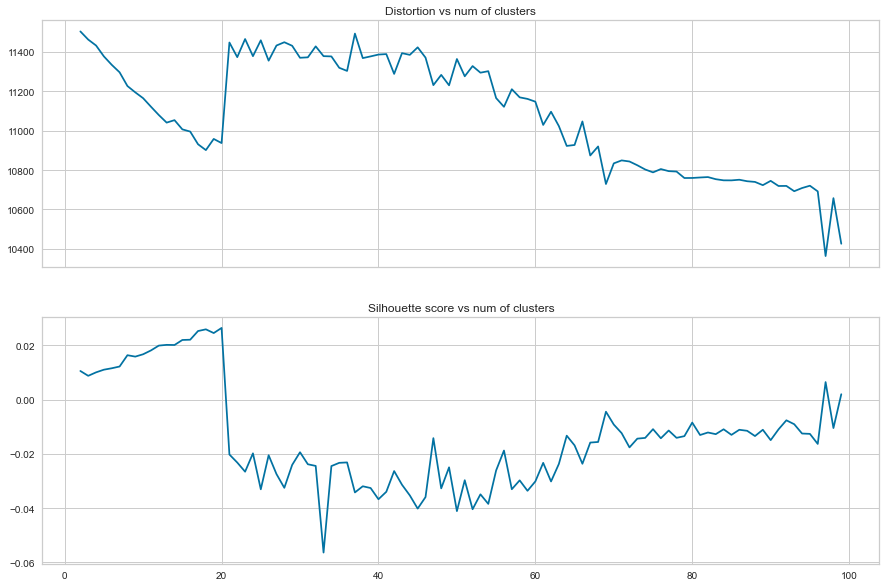

In [157]:
find_optimal_cluster(exclusion_vector_covid,max_cluster=100)

20 topics looks about right. Distortion hits a low and silhouette score peaks.

In [158]:
exclusion_covid['label'],exclusion_keyword_df_covid,exclusion_kmean_covid=apply_kmean(exclusion_vector_covid,20,exclusion_vectorizer_covid)

In [159]:
exclusion_keyword_df_covid

,keyword_0,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7,keyword_8,keyword_9
topic_0,consent,informed,informed consent,provide,inability,provide informed,unable,written,inability provide,sign
topic_1,age,year,le year,age le,le,year age,year old,old,age year,greater year
topic_2,le,count,count le,platelet,platelet count,neutrophil,le cell,cell,weight le,weight
topic_3,study,greater,subject,use,covid,investigator,condition,severe,medication,disorder
topic_4,breastfeeding,pregnant breastfeeding,pregnant,breastfeeding woman,woman,woman pregnant,female,breastfeeding female,female pregnant,patient pregnant
topic_5,pregnant,woman,pregnant woman,lactating,pregnant lactating,lactating woman,breast feeding,feeding,breast,pregnant breast
topic_6,treatment,therapy,anti,corticosteroid,immunosuppressive,drug,month,day,inhibitor,covid
topic_7,history,reaction,allergic,allergic reaction,vaccine,severe,known,alcohol,drug,component
topic_8,patient,study,covid,care,ventilation,mechanical,guardianship,mechanical ventilation,receiving,patient receiving
topic_9,pregnancy,pregnancy breastfeeding,breastfeeding,pregnancy breast,breast feeding,feeding,breast,known pregnancy,known,intrauterine


Exclusion clusters appear to be:
- covid vaccination
- recieving current covid treatment
- age
- renal function
- pregnant
- breast feeding
- alcohol or drug abuse
- investigator opinion
- on ventilator 
- in clinical trial
- chronic liver or autoimmune disease
- history of allergic reaction
- cov infection
- platelet count
- consent

15 cohesive topics out of 20.

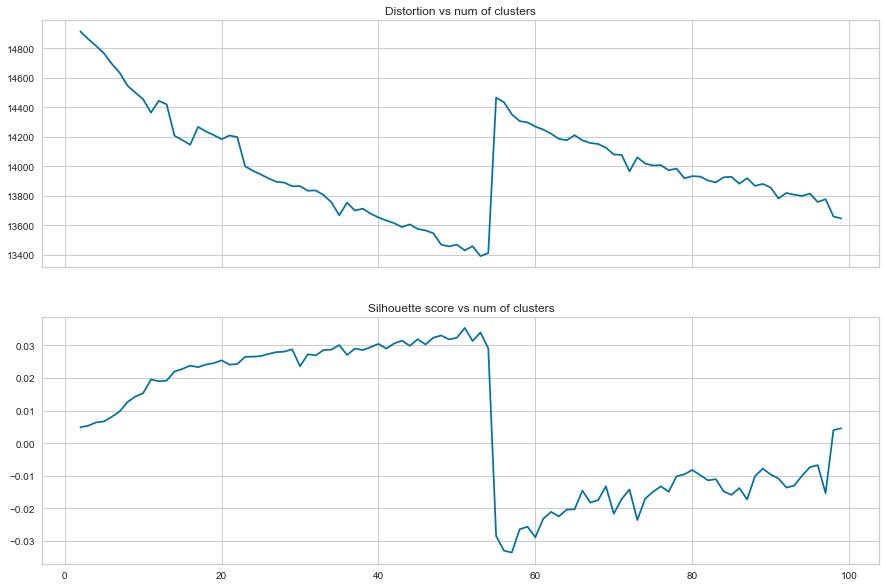

In [160]:
find_optimal_cluster(outcome_vector_covid,max_cluster=100)

In [161]:
outcome_covid['label'],outcome_keyword_df_covid,outcome_kmean_covid=apply_kmean(outcome_vector_covid,17,outcome_vectorizer_covid)

In [162]:
outcome_keyword_df_covid

,keyword_0,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7,keyword_8,keyword_9
topic_0,time,measured,covid,participant,day,symptom,test,blood,study,rate
topic_1,mortality,cause,cause mortality,mortality rate,mortality day,day,rate,death cause,death,day mortality
topic_2,level,blood,lab,clinical lab,evaluation,lab evaluation,clinical,serum,evaluation level,change
topic_3,hospitalized,requiring,oxygen,hospitalized requiring,limitation activity,limitation,supplemental,supplemental oxygen,requiring supplemental,activity
topic_4,adverse,event,adverse event,incidence,incidence adverse,vaccination,treatment,adverse reaction,related,reaction
topic_5,patient,proportion,proportion patient,covid,number patient,number,percentage patient,day,percentage,infection
topic_6,ventilation,mechanical,mechanical ventilation,invasive,invasive mechanical,non invasive,non,day,oxygen,invasive ventilation
topic_7,change,baseline,change baseline,treatment,week,load,viral,time,count,value
topic_8,day,day day,measured day,free,free day,measured,icu,stay,hospital,randomization
topic_9,antibody,neutralizing,neutralizing antibody,gmt,titer,geometric,geometric mean,vaccination,sars,sars cov


Outcome clusters appear to be:
- efficacy of study
- days in hospital
- repiratory rate
- antibody
- requiring supplemental oxygen
- blood
- mortality
- viral load
- adverse event/reaction
- change to baseline
- ventilator
- phase of study
- covid symptoms/infection

13 cohesive cluster out of 17.

In [163]:
# label only
inclusion_covid[['label']].to_csv('output/covid_inclusion_label.txt',index=False,header=False)
exclusion_covid[['label']].to_csv('output/covid_exclusion_label.txt',index=False,header=False)
outcome_covid[['label']].to_csv('output/covid_outcome_label.txt',index=False,header=False)

inclusion_covid.to_csv('output/covid_inclusion.csv',index=False)
exclusion_covid.to_csv('output/covid_exclusion_pain_label.csv',index=False)
outcome_covid.to_csv('output/covid_outcome.csv',index=False)